In [26]:
# %matplotlib widget
%matplotlib inline

In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [28]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

Set save data

In [29]:
save_data = False

In [30]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [31]:
# expt_path=os.getcwd()+'\data\data_220623'
# expt_path=os.getcwd()+'\data\data_220712'
# expt_path=os.getcwd()+'\data\data_220801'
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_220929'
# expt_path=os.getcwd()+'\data\data_221007'
# expt_path=os.getcwd()+'\data\data_221020'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path=os.getcwd()+'\data\data_230217'
expt_path=os.getcwd()+'\data\data_230717'
print('Data will be stored in', expt_path)

Data will be stored in c:\_Lib\python\rfsoc\qram_4QR2_BF5\data\data_230717


In [32]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be c:\_Lib\python\rfsoc\qram_4QR2_BF5\config_q3diamond_full688and638_reset.yml


Load config

In [33]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [34]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [63]:
qubit_i = 2
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [36]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

In [24]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [37]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

In [14]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [13]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -71.06906867350231


  0%|          | 0/500 [00:00<?, ?it/s]

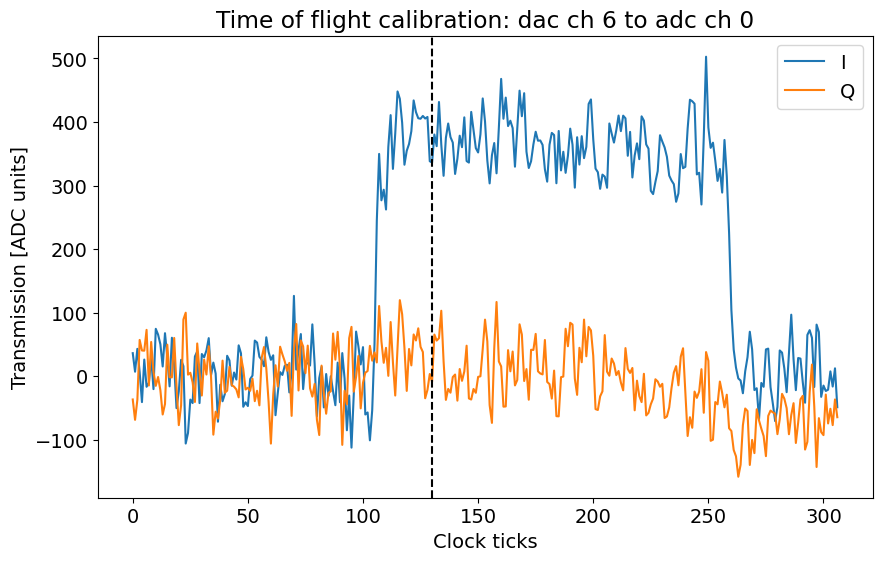

In [14]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [235]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=2000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/150 [00:00<?, ?it/s]

[89.71933333333332, 5000, 1000, 0, 25.181907048737166, 28.7658439091661, -2.9198540815264415]

Freq with minimum transmission: 90.55266666666667
Freq with maximum transmission: 90.27266666666667
From fit:
	f0: 6964.719333333333
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 8.357663200000001
	phi [radians]: 0


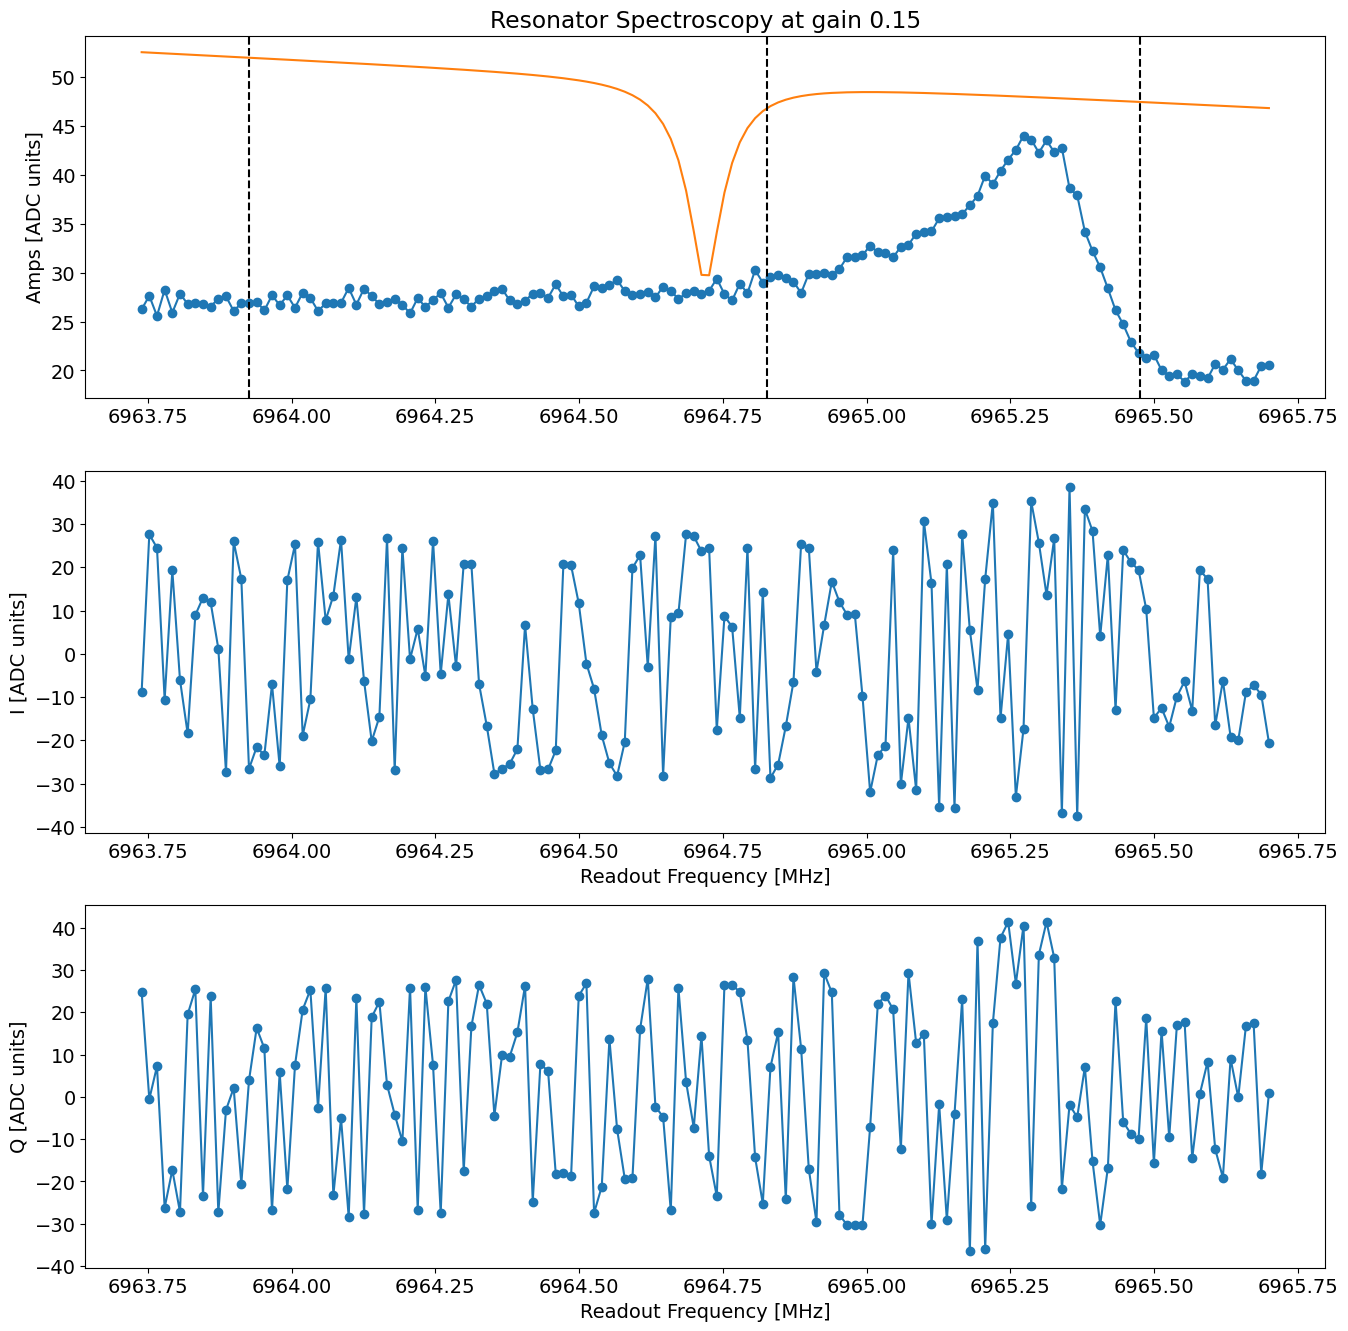

*Set cfg res 3 freq to 90.27266666666667*
*Set cfg res 3 gain to 0.15*
[{'Res freq': 6804.218966666666, 'Res kappa': 0.3200392668544244, 'Qubit freq': 4128.54220329503, 'Pi pulse len': 0.015, 'Pi pulse gain': 28813, 'T1': 54.92027742849027, 'T1 err': 1.1999779954631868, 'T2R': 33.14966646187419, 'T2R err': 3.0781129413207, 'T2E': 29.395511283618028, 'T2E err': 0.8965962410901734, 'Qubit EF freq': 3902.4815326143007, 'EF pi pulse len': 0.0181358074743631, 'EF pi pulse gain': 22566, 'Qubit temp [mK]': 88.742030277723}, {'Res freq': 5790.378, 'Res kappa': 0.9775496000000001, 'Qubit freq': 3457.246518169436, 'Pi pulse len': 0.01948139023573051, 'Pi pulse gain': 670, 'T1': 67.05962756493636, 'T1 err': 2.4658201496776573, 'T2R': 31.442480640172967, 'T2R err': 2.7779747532012267, 'T2E': 29.4711146364028, 'T2E err': 1.6943405102347042, 'Qubit EF freq': 3356.5483393359746, 'EF pi pulse len': 0.02100848977061144, 'EF pi pulse gain': 336, 'Qubit temp [mK]': 85.213662997683}, {'Res freq': 7696.548

In [284]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [237]:
if save_data: saved_files.append(rspec.save_data())

# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [74]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/5), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3456.6570583169314, HWHM 2.480820649746374
Found peak in I at [MHz] 3456.7907134532766, HWHM 2.419950456980223
Found peak in Q at [MHz] 3455.3189468858027, HWHM 1.1663287577798946


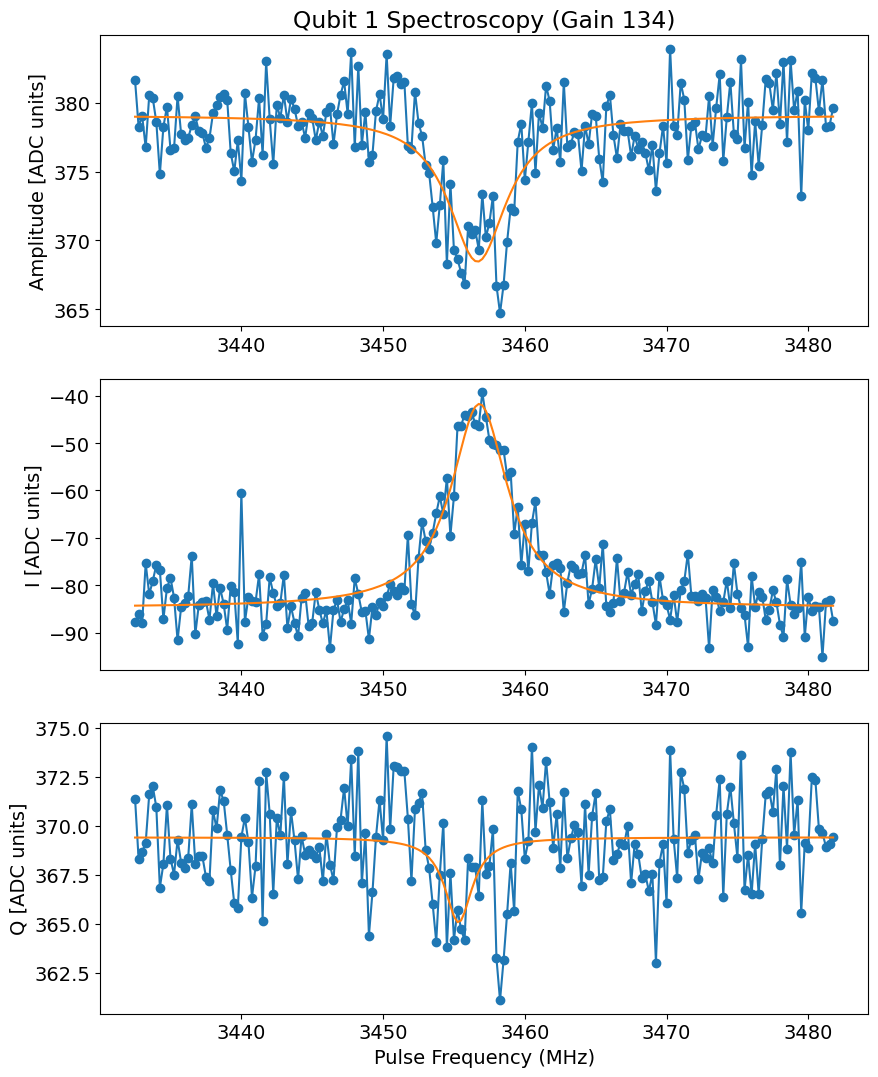

*Set qubit 1 f_ge to 3456.7907134532766*
[{'Qubit freq': 4128.575129385544, 'Pi pulse len': 0.015, 'Pi pulse gain': 29539, 'T1': 45.27851483024968, 'T1 err': 0.8190417235518717, 'T2R': 29.200605671877998, 'T2R err': 5.288198838792158, 'T2E': 23.39090293261674, 'T2E err': 1.6578286986645594, 'Res chi shift (e - g)': -0.8112582781457007, 'Qubit EF freq': 3902.5097729724093, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 25302}, {'Qubit freq': 3456.7907134532766}, {}, {}]


In [75]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [76]:
if save_data: saved_files.append(qspec.save_data())

## Pulse Probe (qubit) spectroscopy round 2

In [139]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 10
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4394.229566744434, HWHM 1.3134875640332273
Found peak in I at [MHz] 4394.233372845039, HWHM 1.2503625340704487
Found peak in Q at [MHz] 4394.228813882691, HWHM 1.3273811430915794


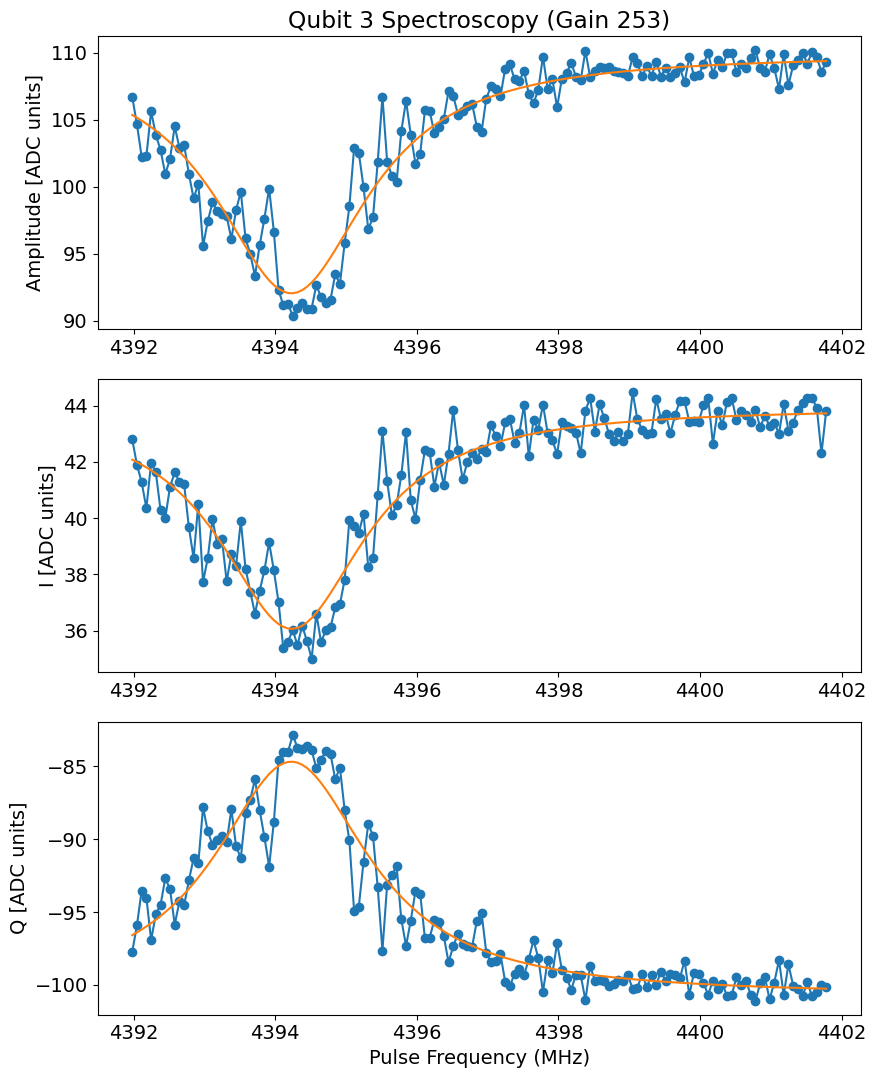

*Set qubit 3 f_ge to 4394.229566744434*
[{'Pi pulse len': 0.015, 'Pi pulse gain': 27232, 'T1': 44.859090500204516, 'T1 err': 0.983378635625101, 'Qubit freq': 4129.446891895333, 'T2R': 15.049351005656305, 'T2R err': 0.9560829390845942, 'Qubit EF freq': 3903.416022184577, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 27083, 't2EFR': 13.789598484893588, 't2EFR err': 0.794178662495287}, {'Qubit freq': 3454.9960740021306, 'Pi pulse len': 0.015, 'Pi pulse gain': 947, 'T1': 57.96626349917495, 'T1 err': 1.9591871148853852, 'T2R': 13.591829305036228, 'T2R err': 0.8038038388572982, 'Qubit EF freq': 3354.521139701014, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 499, 't2EFR': 16.124866271159927, 't2EFR err': 0.8324815414244899}, {'Qubit freq': 4779.596097510133, 'Pi pulse len': 0.015, 'Pi pulse gain': 2325, 'T1': 46.32070989363564, 'T1 err': 1.090259388704458, 'T2R': 12.499131438444053, 'T2R err': 0.7369288796659786, 'Qubit EF freq': 4590.177049031502, 'EF pi pulse len': 0.015, 'EF pi pulse gain

In [140]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [141]:
if save_data: saved_files.append(qspec2.save_data())

## Length Rabi

In [146]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=2000,
    gain=yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]//2, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.6242596202924435
Pi length from avgi data [us]: 0.028766141998285782
	Pi/2 length from avgi data [us]: 0.014383070999142891

Decay from avgq [us] 0.7576089965962733
Pi length from avgq data [us]: 0.028818264872258727
Pi/2 length from avgq data [us]: 0.014409132436129363


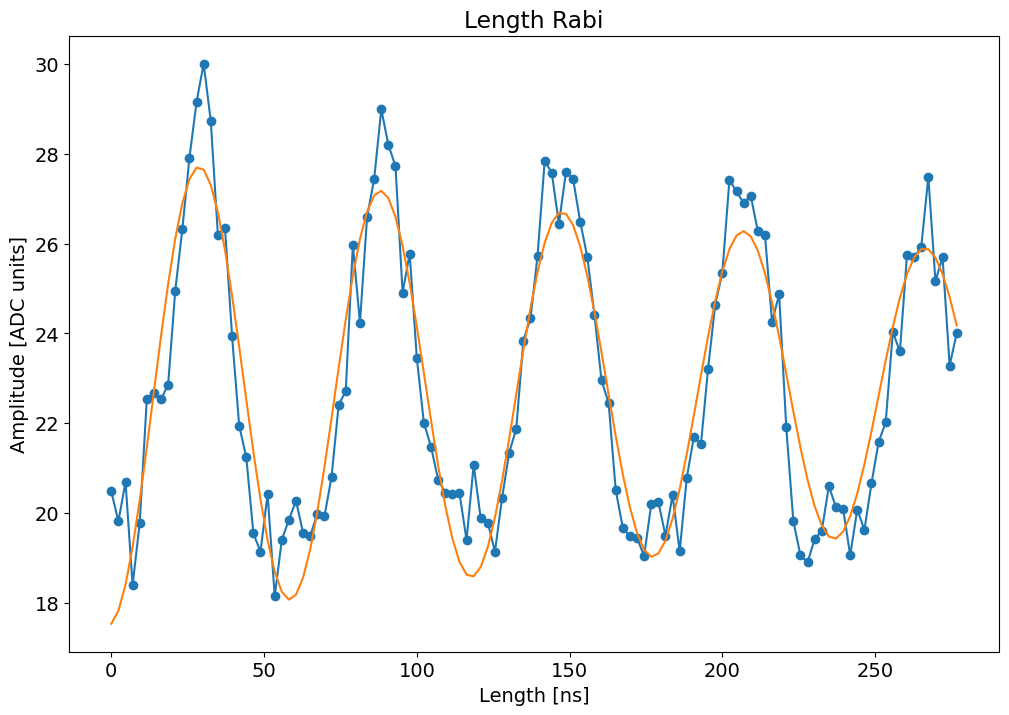

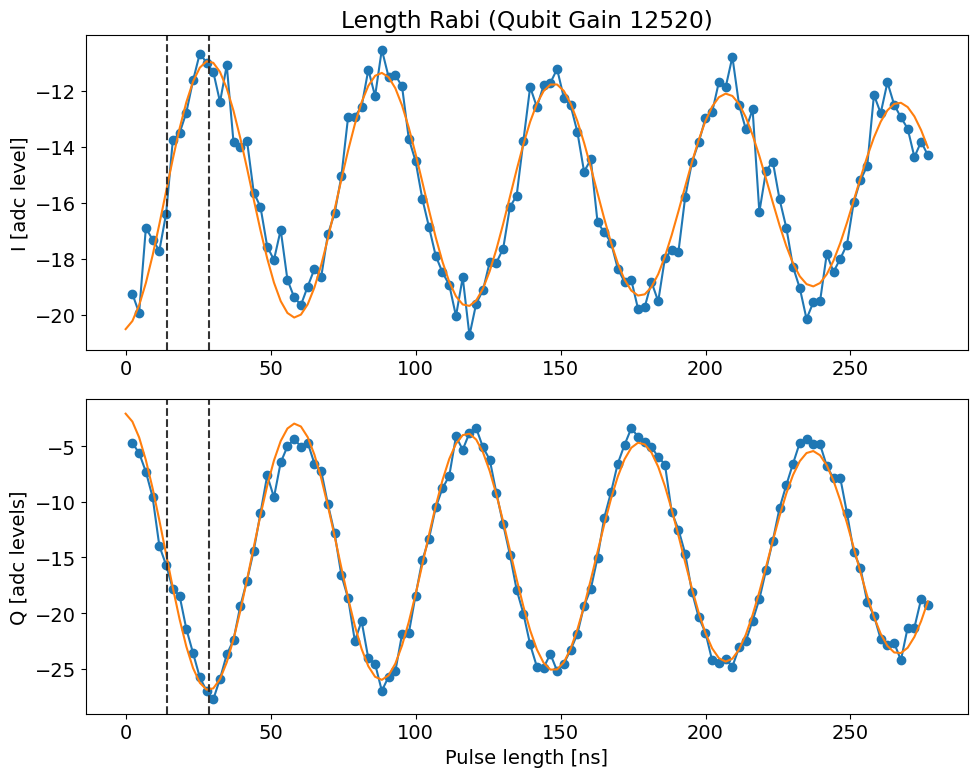

Will use sigma 0.015 for amplitude rabi


In [147]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len/2, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [148]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude Rabi

In [68]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]

In [69]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(2.0*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i])))
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/20 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 2338
	Pi/2 gain from amps data [dac units]: 1169
Pi gain from avgi data [dac units]: 2335
	Pi/2 gain from avgi data [dac units]: 1167
Pi gain from avgq data [dac units]: 2335
	Pi/2 gain from avgq data [dac units]: 1167


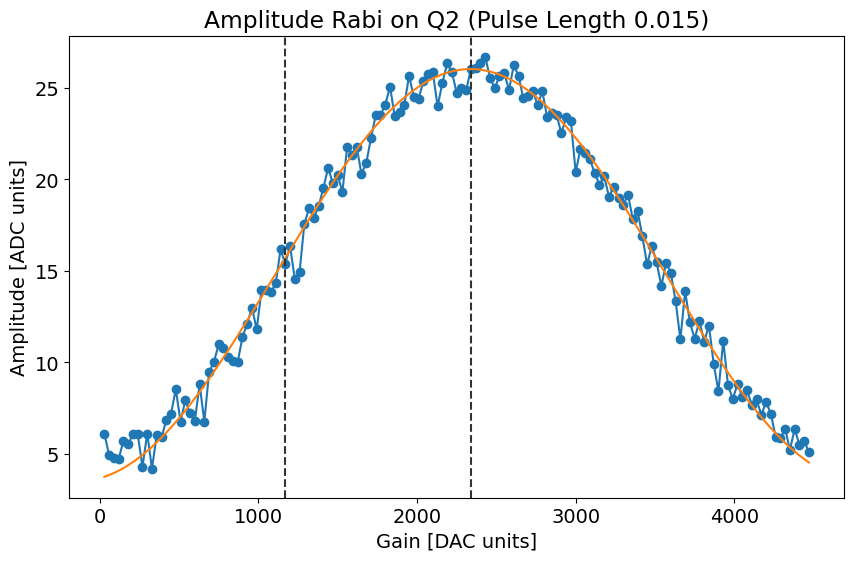

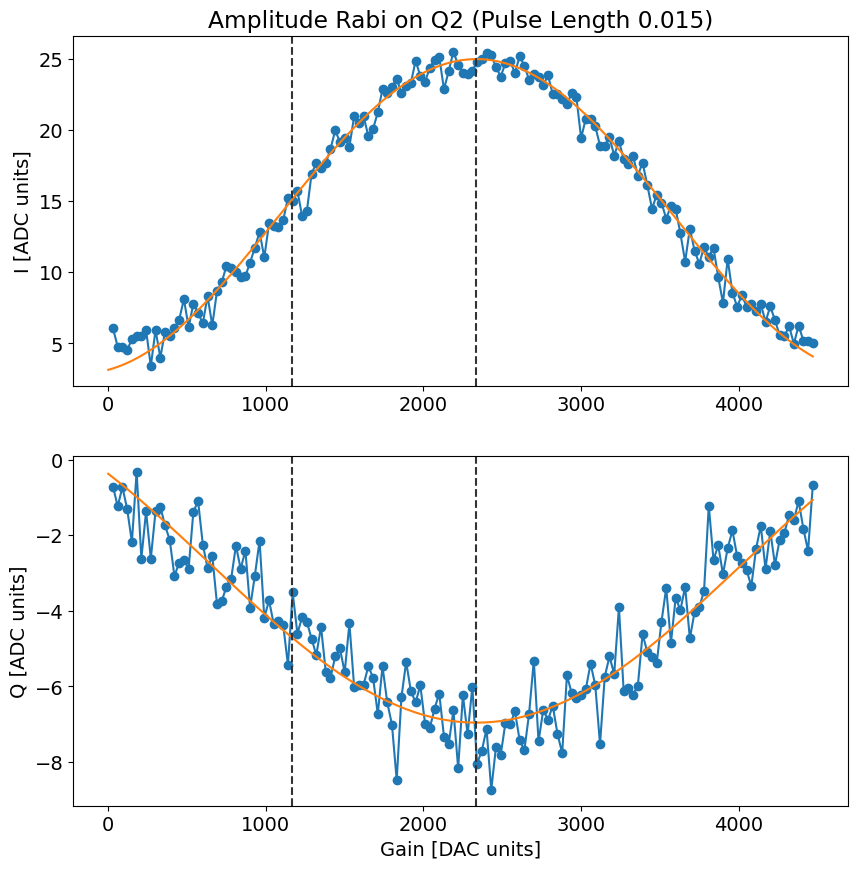

*Set pi pulse sigma for qubit 2 to 0.015*
*Set pi pulse gain for qubit 2 to 2335*
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453, 'T2R': 19.743050159012622, 'T2R err': 1.2349352829614832, 'Qubit freq': 3454.8307022222293}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1647, 'Qubit temp [mK]': 75.0116542249641, 'T2R': 7.718935276862331, 'T2R err': 0.500751239957151, 'Qubit freq': 4779.441948200766, 'Pi pulse len': 0.015, 'Pi pulse gain': 2335}, {}]


In [70]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [151]:
if save_data: saved_files.append(amprabi.save_data())

## $T_1$

In [107]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [145]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Fit T1 avgi [us]: 42.18741923584774
Fit T1 avgq [us]: 43.64447263218076


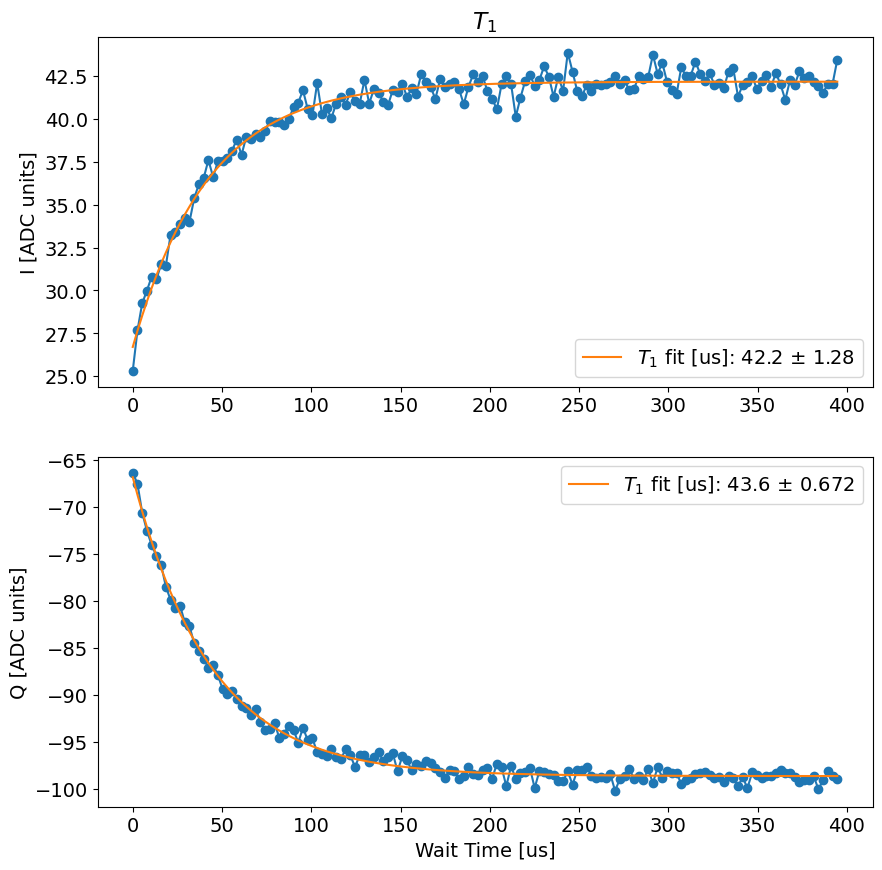

*Set qubit 3 T1 to 43.0*
*Set readout 3 relax delay to 130.0*
[{'Pi pulse len': 0.015, 'Pi pulse gain': 27232, 'T1': 44.859090500204516, 'T1 err': 0.983378635625101, 'Qubit freq': 4129.446891895333, 'T2R': 15.049351005656305, 'T2R err': 0.9560829390845942, 'Qubit EF freq': 3903.416022184577, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 27083, 't2EFR': 13.789598484893588, 't2EFR err': 0.794178662495287}, {'Qubit freq': 3454.9960740021306, 'Pi pulse len': 0.015, 'Pi pulse gain': 947, 'T1': 57.96626349917495, 'T1 err': 1.9591871148853852, 'T2R': 13.591829305036228, 'T2R err': 0.8038038388572982, 'Qubit EF freq': 3354.521139701014, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 499, 't2EFR': 16.124866271159927, 't2EFR err': 0.8324815414244899}, {'Qubit freq': 4779.596097510133, 'Pi pulse len': 0.015, 'Pi pulse gain': 2325, 'T1': 46.32070989363564, 'T1 err': 1.090259388704458, 'T2R': 12.499131438444053, 'T2R err': 0.7369288796659786, 'Qubit EF freq': 4590.177049031502, 'EF pi pulse len': 0.

In [146]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [147]:
if save_data: saved_files.append(t1.save_data())

## $T_2$ Ramsey round 1

In [58]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 3457.246518169436
qubit_hwhm = 2
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [149]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(5), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=250,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=20,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Ramsey freq [MHz]: 2.0


  0%|          | 0/20 [00:00<?, ?it/s]

Current pi pulse frequency: 4394.229566744434
Fit frequency from amps [MHz]: 3.1303895375708795 +/- 0.032363652577621915
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4393.099177206863
 	4389.099177206863
T2 Ramsey from fit amps [us]: 0.8649553571428572
Current pi pulse frequency: 4394.229566744434
Fit frequency from I [MHz]: 3.1331924022763475 +/- 0.03132355565891157
Suggested new pi pulse frequency from fit I [MHz]:
 	4393.096374342158
 	4389.096374342158
T2 Ramsey from fit I [us]: 0.8649553571428572
Fit frequency from Q [MHz]: 1.70337306357721 +/- 0.0050033928921157135
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4394.5261936808565
 	4390.5261936808565
T2 Ramsey from fit Q [us]: 1.9374559060568086


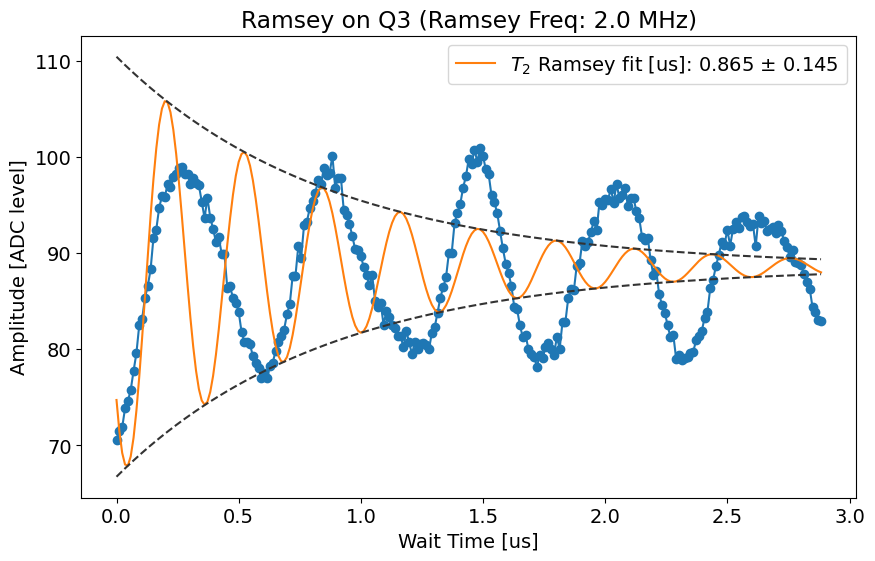

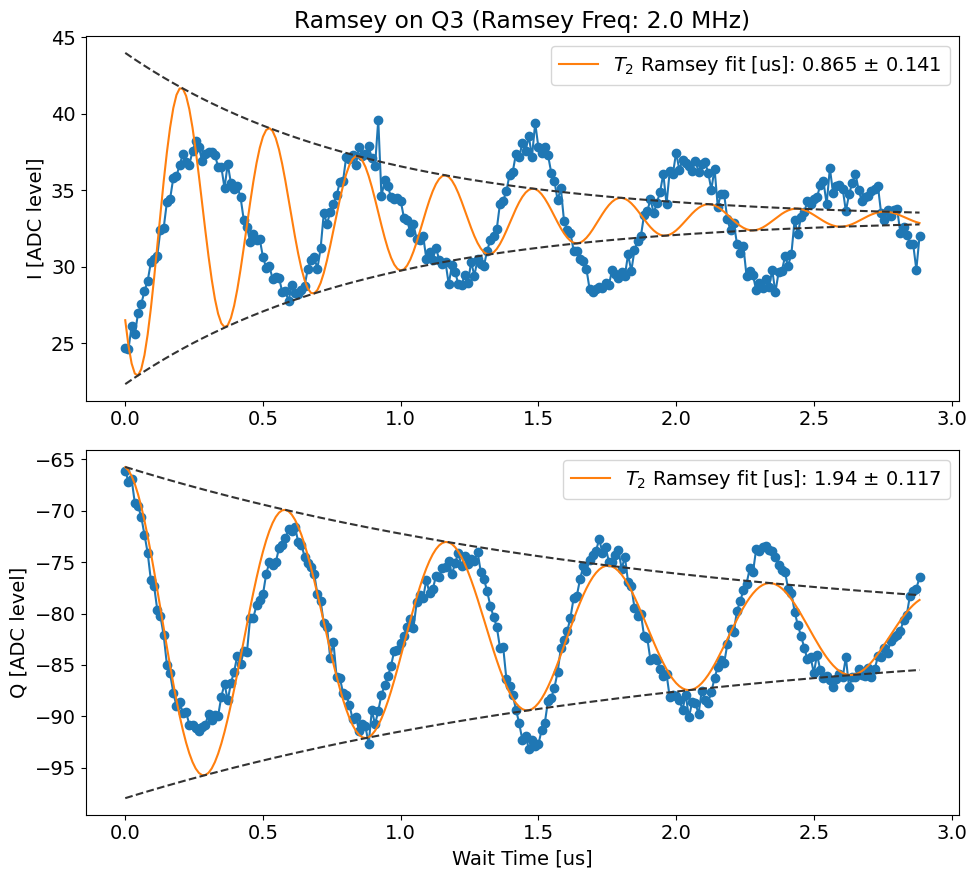

*Set qubit 3 freq to 4394.5261936808565*
Alt qubit freq is 4390.5261936808565


In [150]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [151]:
if save_data: saved_files.append(t2r.save_data())

## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [71]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(10) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    step=soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4779.441948200766
Fit frequency from amps [MHz]: 0.20037740154242617 +/- 0.00107193840194922
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4779.441570799224
 	4779.041570799223
T2 Ramsey from fit amps [us]: 10.571051685196025
Current pi pulse frequency: 4779.441948200766
Fit frequency from I [MHz]: 0.20048188652717172 +/- 0.0010880178754458702
Suggested new pi pulse frequency from fit I [MHz]:
 	4779.441466314239
 	4779.041466314239
T2 Ramsey from fit I [us]: 10.687146988704392
Fit frequency from Q [MHz]: 0.3614243441878176 +/- 0.006646065347206481
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4779.280523856578
 	4778.880523856578
T2 Ramsey from fit Q [us]: 6.236049107142858


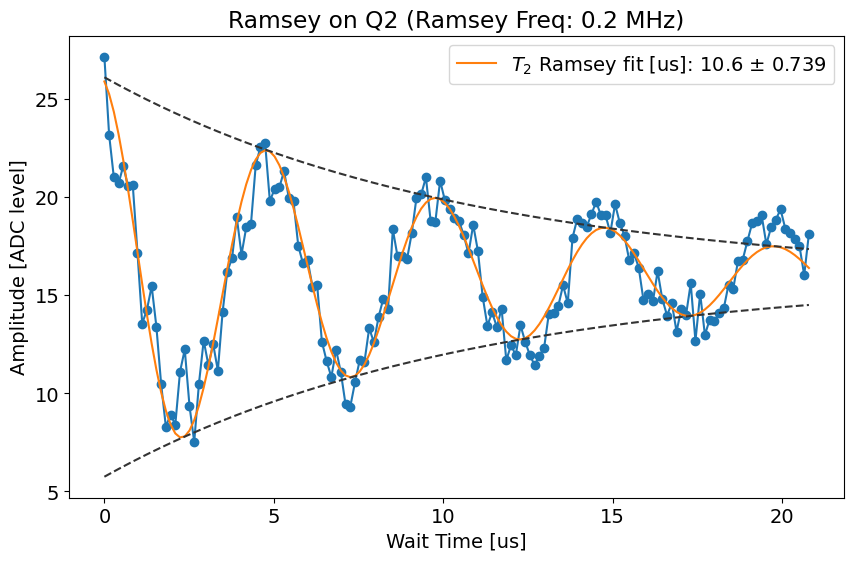

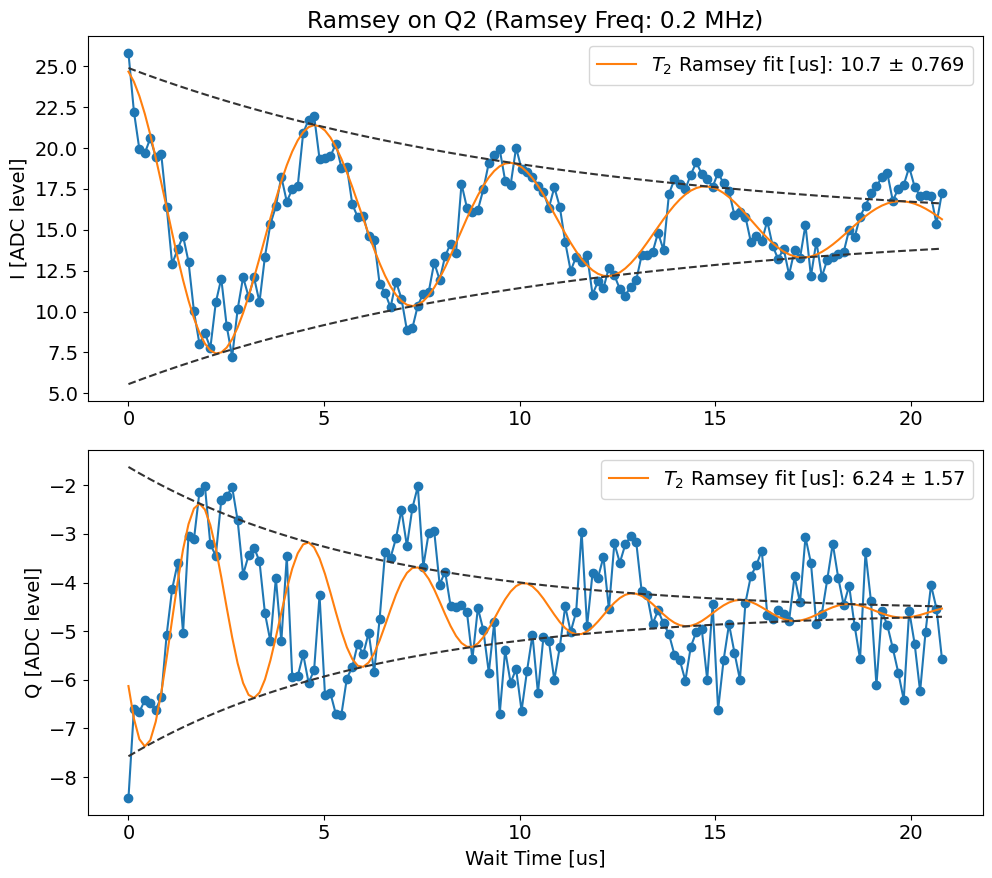

*Set qubit 2 freq to 4779.441570799224*
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453, 'T2R': 19.743050159012622, 'T2R err': 1.2349352829614832, 'Qubit freq': 3454.8307022222293}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1647, 'Qubit temp [mK]': 75.0116542249641, 'T2R': 10.571051685196025, 'T2R err': 0.7394386604494612, 'Qubit freq': 4779.441570799224, 'Pi pulse len': 0.015, 'Pi pulse gain': 2335}, {}]
Redo T2R: False


In [72]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= ramsey_freq:
# if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [154]:
if save_data: saved_files.append(t2r_2.save_data())

## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [97]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubits=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

In [98]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

Attempted to init fitparam 1 to 13.189119999999999, which is out of bounds 0.02886442953020134 to 4.329664429530201. Instead init to 2.179264429530201


TypeError: get_best_fit() got an unexpected keyword argument 'compare_param_i'

In [ ]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [162]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max((ramsey_freq/10, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.6879999999999997, which is out of bounds 0.0036080536912751677 to 0.5412080536912751. Instead init to 0.27240805369127513
Attempted to init fitparam 1 to 2.6879999999999997, which is out of bounds 0.0036080536912751677 to 0.5412080536912751. Instead init to 0.27240805369127513
Current qubit frequency: 4394.480407282836
Fit frequency from I [MHz]: 0.19954787147618383 +/- 0.0005354153756011742
T2 Echo from fit I [us]: 13.140991493370253
Fit frequency from Q [MHz]: 0.19994167896271026 +/- 0.00025122805387190936
T2 Echo from fit Q [us]: 16.32896897206364


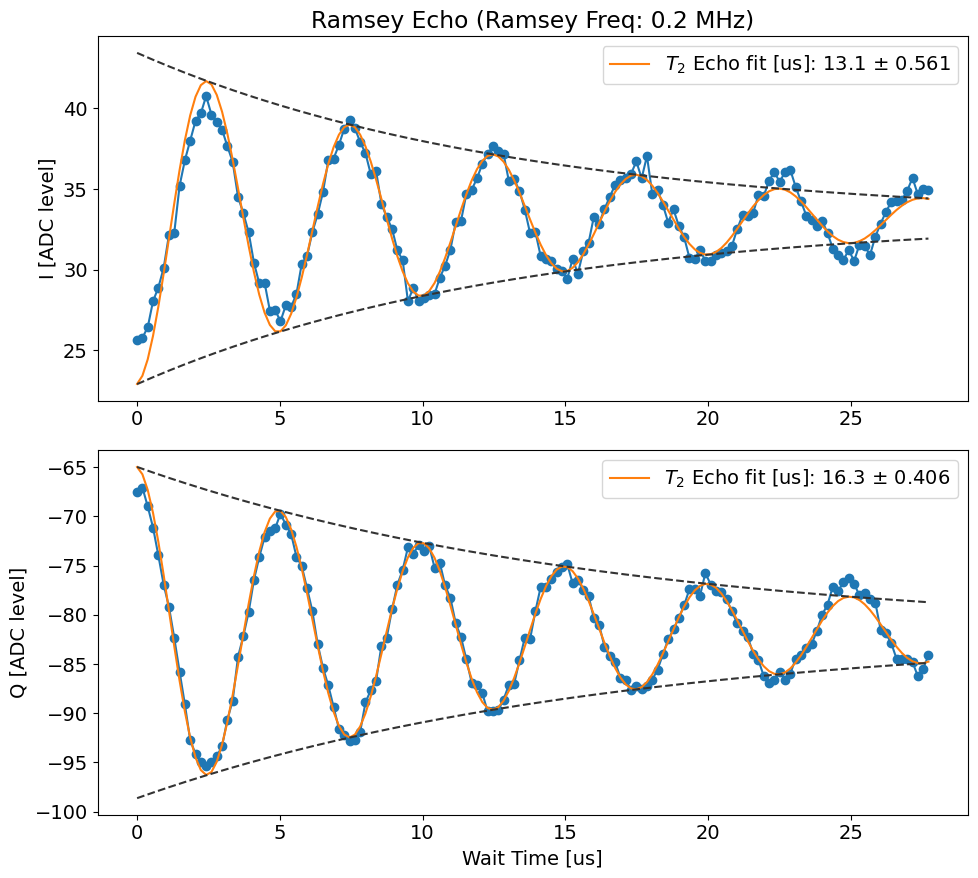

[{'Pi pulse len': 0.015, 'Pi pulse gain': 27232, 'T1': 44.859090500204516, 'T1 err': 0.983378635625101, 'Qubit freq': 4129.446891895333, 'T2R': 15.049351005656305, 'T2R err': 0.9560829390845942, 'Qubit EF freq': 3903.416022184577, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 27083, 't2EFR': 13.789598484893588, 't2EFR err': 0.794178662495287}, {'Qubit freq': 3454.9960740021306, 'Pi pulse len': 0.015, 'Pi pulse gain': 947, 'T1': 57.96626349917495, 'T1 err': 1.9591871148853852, 'T2R': 13.591829305036228, 'T2R err': 0.8038038388572982, 'Qubit EF freq': 3354.521139701014, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 499, 't2EFR': 16.124866271159927, 't2EFR err': 0.8324815414244899}, {'Qubit freq': 4779.596097510133, 'Pi pulse len': 0.015, 'Pi pulse gain': 2325, 'T1': 46.32070989363564, 'T1 err': 1.090259388704458, 'T2R': 12.499131438444053, 'T2R err': 0.7369288796659786, 'Qubit EF freq': 4590.177049031502, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 1633, 't2EFR': 15.058213893487403, 't

In [164]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [53]:
if save_data: saved_files.append(t2e.save_data())

# Resonator chi shift (g/e)

In [54]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-71.08562496489304, 5000, 1000, 0, 49.29640171925196, 89.60430287966606, -2.4478213610217976]
[-72.08116339 205.57660367 749.86379961  -1.33358469 133.42348157
  65.68886484  -2.64352143]

Freq with minimum transmission: -71.88032695164802
Freq with maximum transmission: -72.27767794502549
From fit:
	f0: 6802.918836611603
	Qi: 205.57660367412203
	Qe: 749.8637996145284
	Q0: 161.34387096497446
	kappa [MHz]: 42.16409830707746
	phi [radians]: -1.3335846943019098


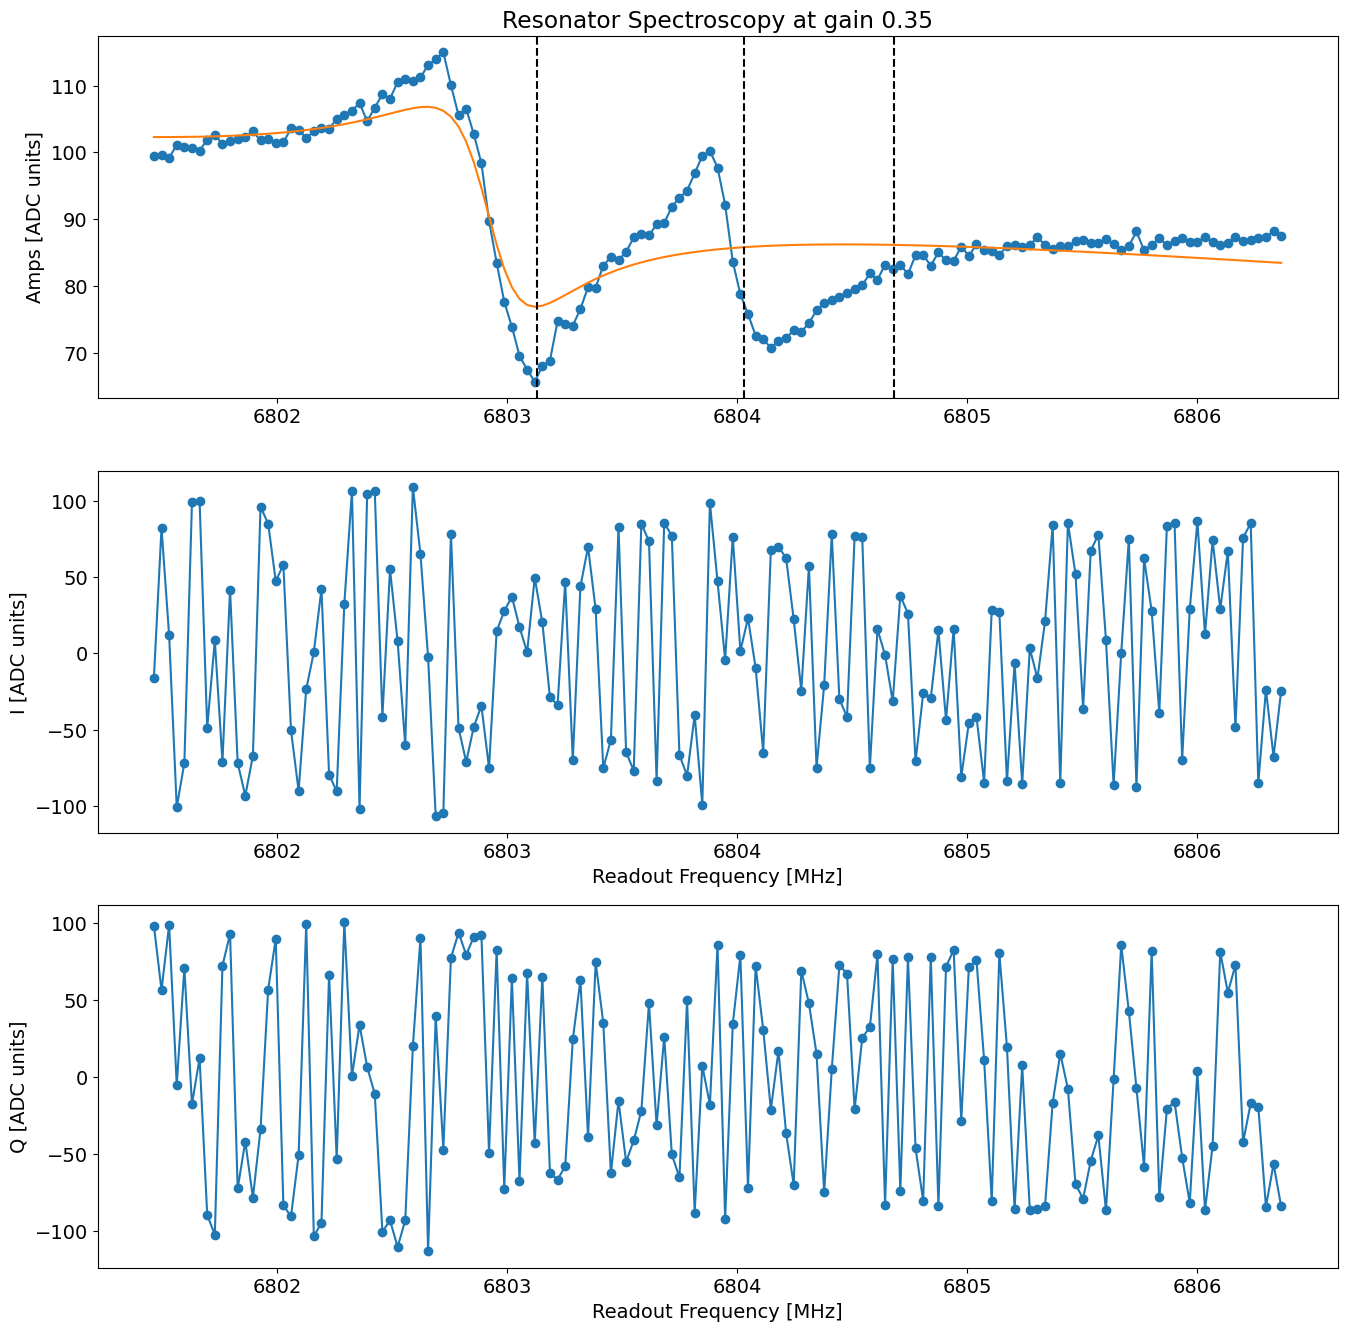

[{'Qubit freq': 4128.575129385544, 'Pi pulse len': 0.015, 'Pi pulse gain': 29539, 'T1': 45.27851483024968, 'T1 err': 0.8190417235518717, 'T2R': 29.200605671877998, 'T2R err': 5.288198838792158, 'T2E': 23.39090293261674, 'T2E err': 1.6578286986645594, 'Res chi shift (e - g)': -0.8112582781457007}, {}, {}, {}]


In [55]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [56]:
if save_data: saved_files.append(rspec_chi.save_data())

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [ ]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/30), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

Found peak in amps at [MHz] 4587.706384513445, HWHM -0.9371387846313942
Found peak in I at [MHz] 4587.910005021505, HWHM 1.4835933982637253
Found peak in Q at [MHz] 4587.880034204862, HWHM 1.5587561778327095


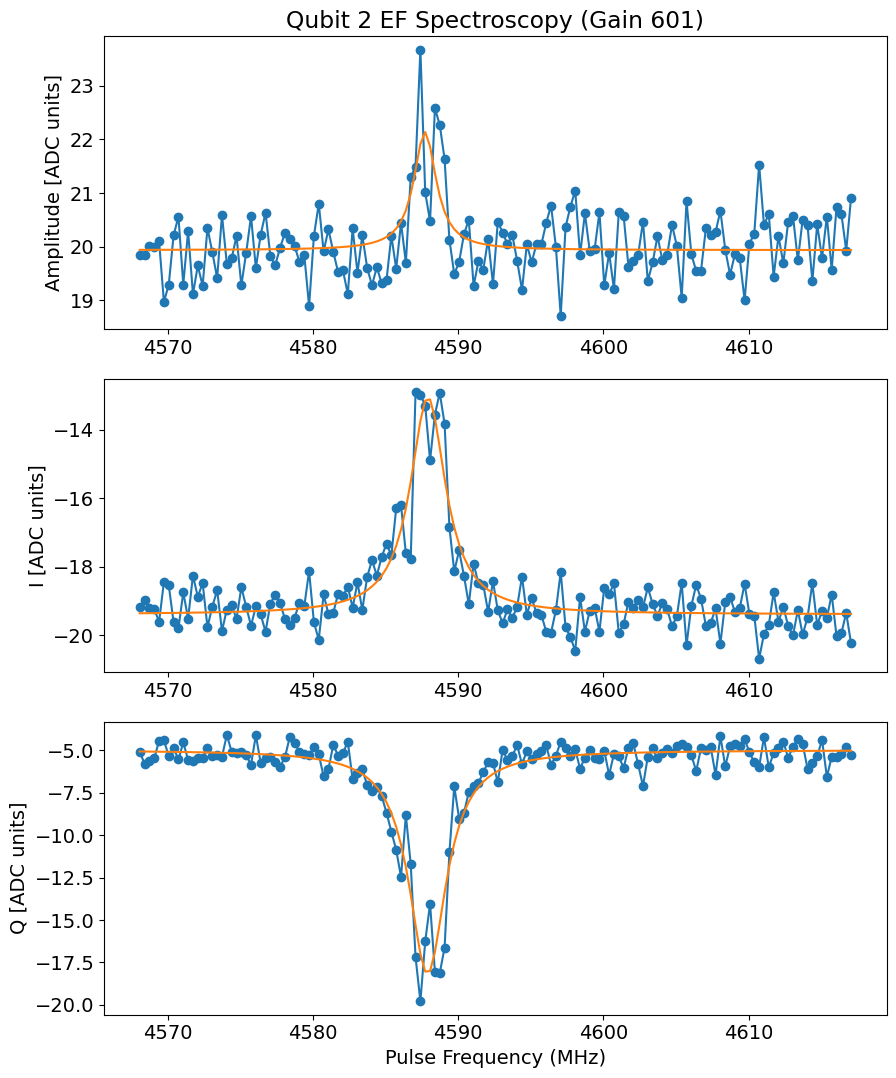

*Set qubit 2 f_ef to 4587.880034204862*
[{'Qubit freq': 4128.575129385544, 'Pi pulse len': 0.015, 'Pi pulse gain': 29539, 'T1': 45.27851483024968, 'T1 err': 0.8190417235518717, 'T2R': 29.200605671877998, 'T2R err': 5.288198838792158, 'T2E': 23.39090293261674, 'T2E err': 1.6578286986645594, 'Res chi shift (e - g)': -0.8112582781457007, 'Qubit EF freq': 3902.5097729724093, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 25302}, {'Qubit freq': 3457.338723559245, 'Pi pulse len': 0.015, 'Pi pulse gain': 824, 'T1': 127.27209596517176, 'T1 err': 28.208991776605572, 'T2R': 9.895029434621184, 'T2R err': 5.180248624952173, 'Qubit EF freq': 3356.650995689788, 'Qubit temp [mK]': 101.2961810320154}, {'T2R': 14.425708295820465, 'T2R err': 1.5470471655565434, 'Qubit freq': 4782.994651953712, 'Qubit EF freq': 4587.880034204862, 'Pi pulse len': 0.015, 'Pi pulse gain': 25454}, {}]


In [163]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [ ]:
if save_data: saved_files.append(qEFspec.save_data())

## Pulse Probe EF spectroscopy round 2

In [155]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/50), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4221.451752202131, HWHM 2.377509555984383
Found peak in I at [MHz] 4221.505750903381, HWHM 2.274664565686031
Found peak in Q at [MHz] 4221.440505223409, HWHM 2.400254744850462


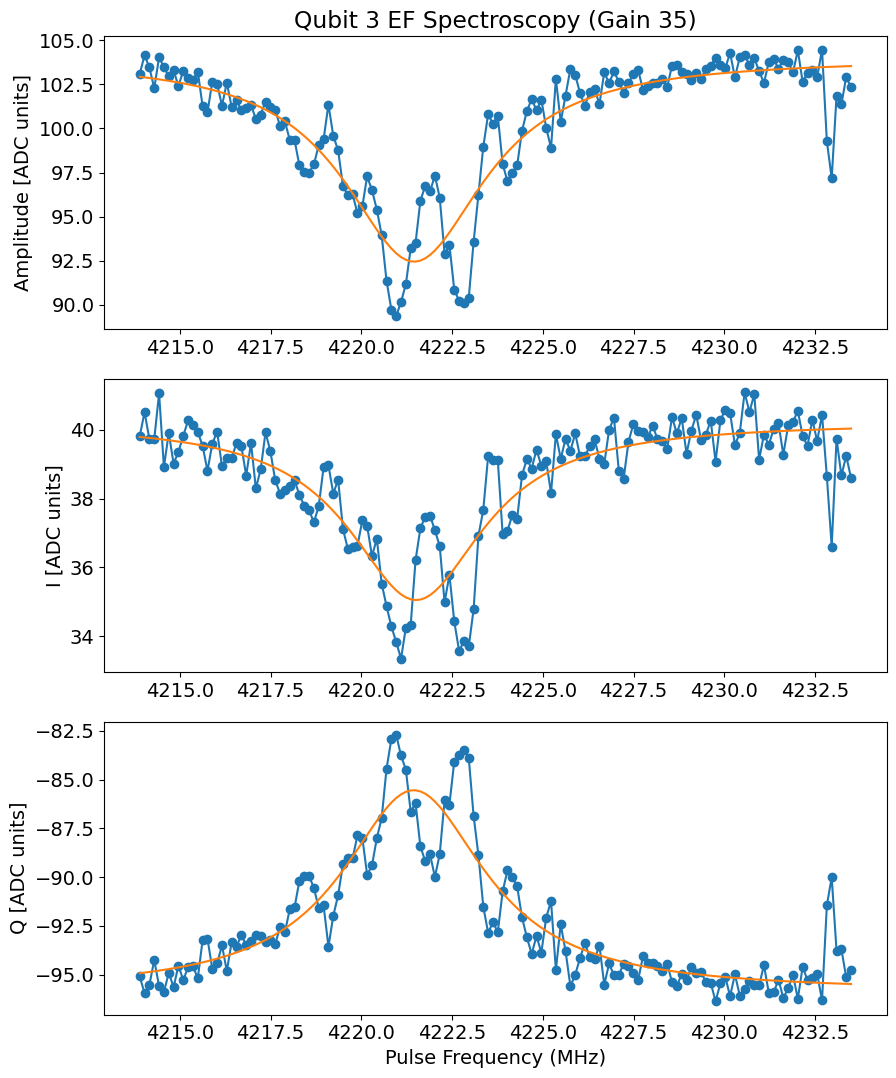

*Set qubit 3 f_ef to 4221.440505223409*
[{'Pi pulse len': 0.015, 'Pi pulse gain': 27232, 'T1': 44.859090500204516, 'T1 err': 0.983378635625101, 'Qubit freq': 4129.446891895333, 'T2R': 15.049351005656305, 'T2R err': 0.9560829390845942, 'Qubit EF freq': 3903.416022184577, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 27083, 't2EFR': 13.789598484893588, 't2EFR err': 0.794178662495287}, {'Qubit freq': 3454.9960740021306, 'Pi pulse len': 0.015, 'Pi pulse gain': 947, 'T1': 57.96626349917495, 'T1 err': 1.9591871148853852, 'T2R': 13.591829305036228, 'T2R err': 0.8038038388572982, 'Qubit EF freq': 3354.521139701014, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 499, 't2EFR': 16.124866271159927, 't2EFR err': 0.8324815414244899}, {'Qubit freq': 4779.596097510133, 'Pi pulse len': 0.015, 'Pi pulse gain': 2325, 'T1': 46.32070989363564, 'T1 err': 1.090259388704458, 'T2R': 12.499131438444053, 'T2R err': 0.7369288796659786, 'Qubit EF freq': 4590.177049031502, 'EF pi pulse len': 0.015, 'EF pi pulse gain

In [156]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [120]:
if save_data: saved_files.append(qEFspec2.save_data())

## Length EF Rabi

In [121]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i], # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.09307689343814744
Pi length from avgi data [us]: 0.014746686411877817
	Pi/2 length from avgi data [us]: 0.007373343205938908

Decay from avgq [us] 0.2757473108306491
Pi length from avgq data [us]: 0.015086869040936809
Pi/2 length from avgq data [us]: 0.007543434520468404


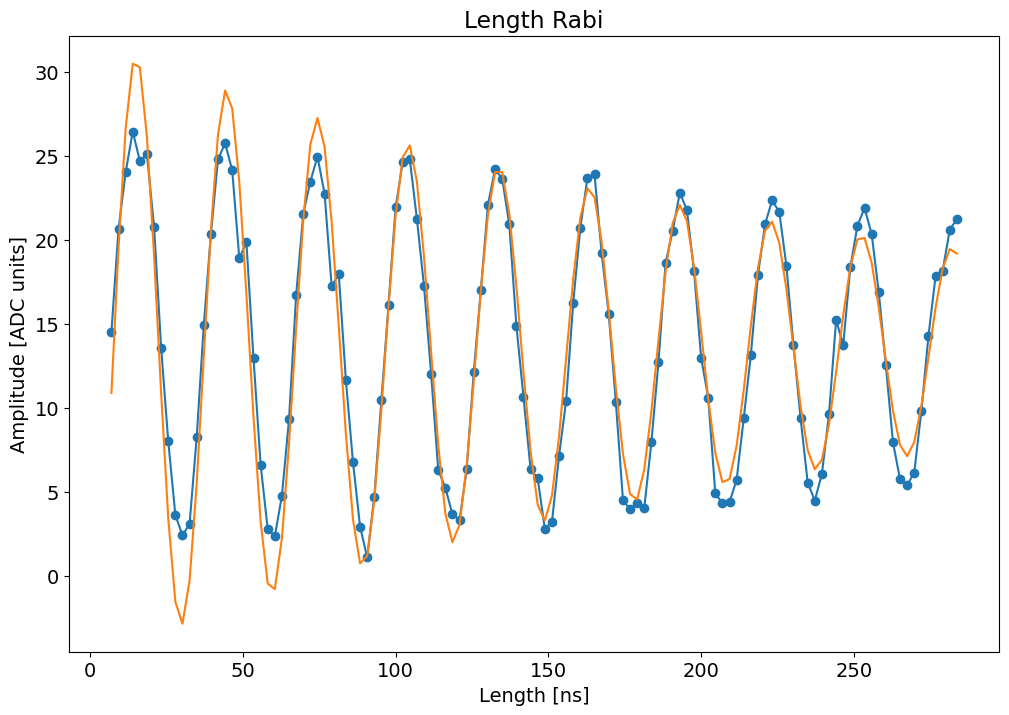

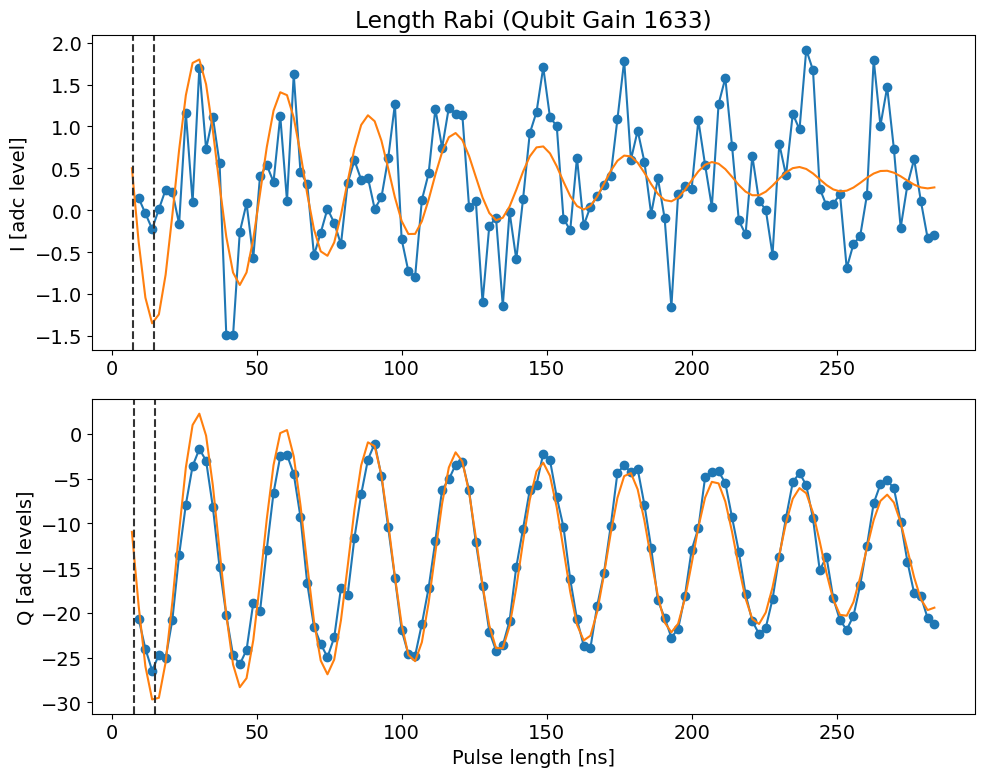

Will use sigma 0.015 for amplitude rabi EF


In [122]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [123]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [47]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]

In [85]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i])))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 1638
	Pi/2 gain from amps data [dac units]: 819
Pi gain from avgi data [dac units]: 1638
	Pi/2 gain from avgi data [dac units]: 819
Pi gain from avgq data [dac units]: 1655
	Pi/2 gain from avgq data [dac units]: 827


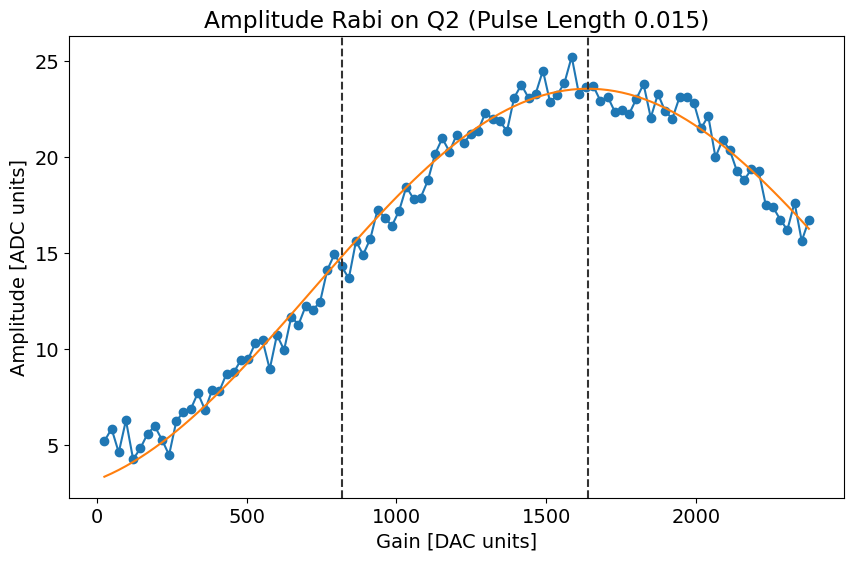

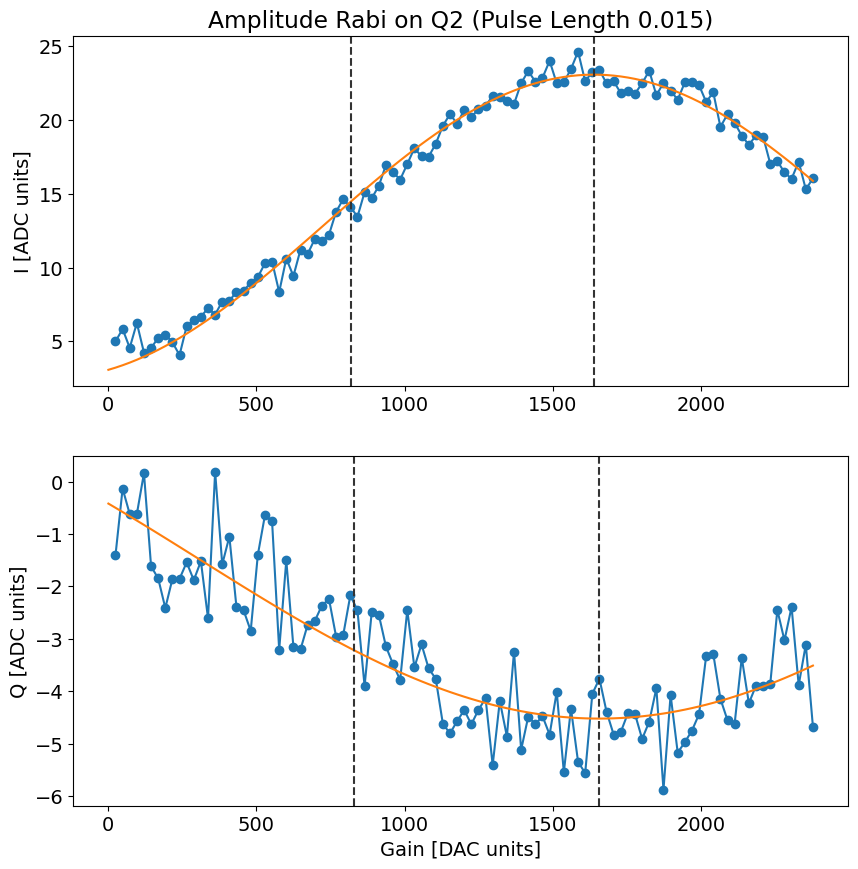

*Set EF pi pulse sigma for qubit 2 to 0.015*
*Set EF pi pulse gain for qubit 2 to 1638*
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453, 'T2R': 19.743050159012622, 'T2R err': 1.2349352829614832, 'Qubit freq': 3454.8307022222293}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1638, 'Qubit temp [mK]': 75.0116542249641, 'T2R': 10.571051685196025, 'T2R err': 0.7394386604494612, 'Qubit freq': 4779.441570799224, 'Pi pulse len': 0.015, 'Pi pulse gain': 2335, 't2EFR': 6.236049107142858, 't2EFR err': 1.1356721533115515, 'Qubit EF freq': 4590.224612548705}, {}]


In [86]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [50]:
if save_data: saved_files.append(amprabiEF.save_data())

## Qubit temperature

In [51]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i])))
npts = 101

amprabiEF2.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.014166666666666668, which is out of bounds 4.208754208754209e-05 to 0.004208754208754209. Instead init to 0.0021254208754208754
yscale normal: 19.21126372046227
yscale no pulse: 0.9025897115263639
Pi gain from amps data [dac units]: 7183
	Pi/2 gain from amps data [dac units]: 3591
Pi gain from avgi data [dac units]: 7397
	Pi/2 gain from avgi data [dac units]: 3698
Pi gain from avgq data [dac units]: 163
	Pi/2 gain from avgq data [dac units]: 81


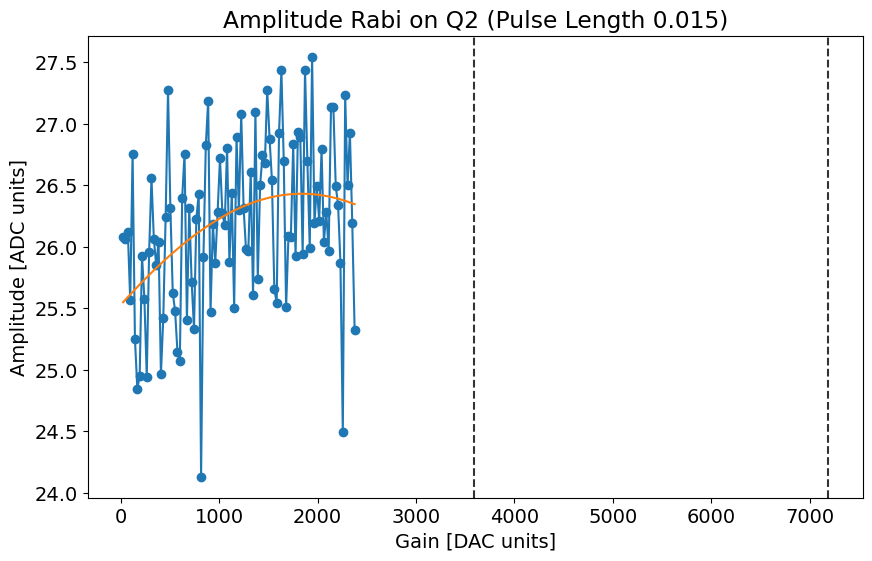

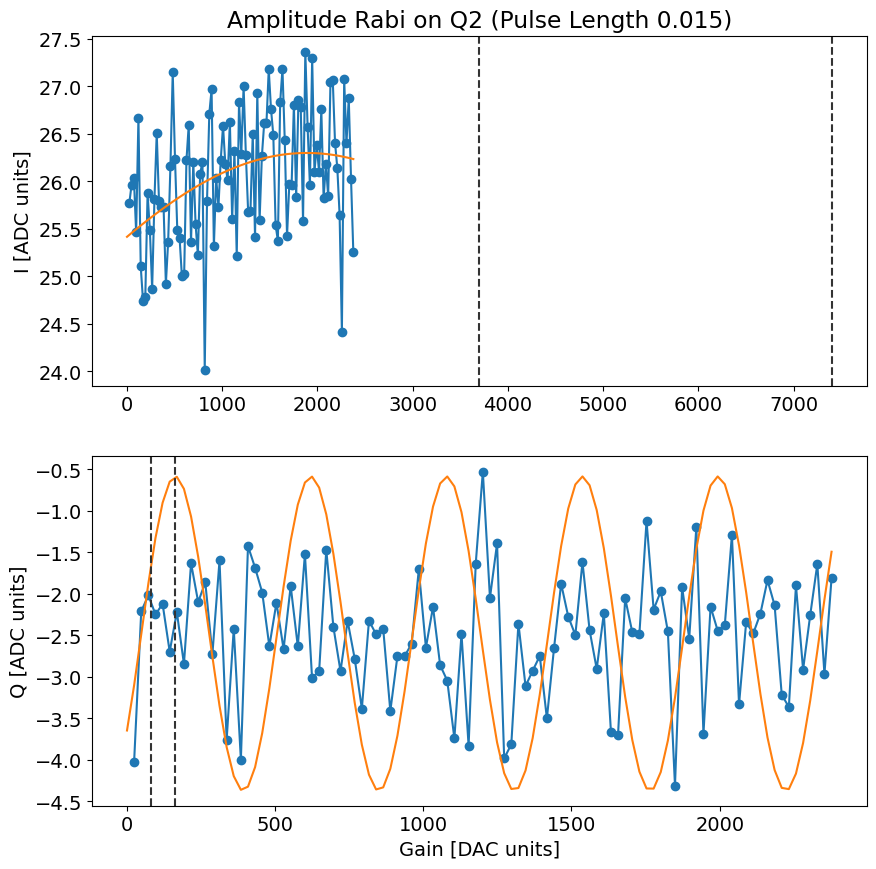

Qubit temp [mK]: 75.0116542249641
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1647, 'Qubit temp [mK]': 75.0116542249641}, {}]


In [52]:
# TESTING
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

amprabiEF2.analyze(fit=True)

amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

amprabiEF_amps = amprabiEF.data['amps']
p = amprabiEF.data['fit_amps']
# efamp_normal = p[0]
efamp_normal = max(amprabiEF.data['amps']) - min(amprabiEF.data['amps'])

amprabiEF2_amps = amprabiEF2.data['amps']
p = amprabiEF2.data['fit_amps']
fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
efamp_nopulse = max(fit_vals) - min(fit_vals)

print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

amprabiEF2.display(fit=True)

print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print(all_results)

In [25]:
if save_data: saved_files.append(amprabiEF2.save_data())

## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [79]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubitEF_hwhm = 7
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))
# short_T1 = False

In [82]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4590.196935123076
Fit frequency from amps [MHz]: 2.972322574371204 +/- 0.008402556618783214
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4590.224612548705
 	4584.224612548705
T2 Ramsey from fit amps [us]: 1.6979091724352855
Current pi pulse frequency: 4590.196935123076
Fit frequency from I [MHz]: 2.973231432353516 +/- 0.008366181825620824
Suggested new pi pulse frequency from fit I [MHz]:
 	4590.223703690723
 	4584.223703690723
T2 Ramsey from fit I [us]: 1.7337471771449673
Fit frequency from Q [MHz]: 0.45207497565250304 +/- 0.11768767220372191
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4592.744860147424
 	4586.744860147424
T2 Ramsey from fit Q [us]: 1.0393415178577883


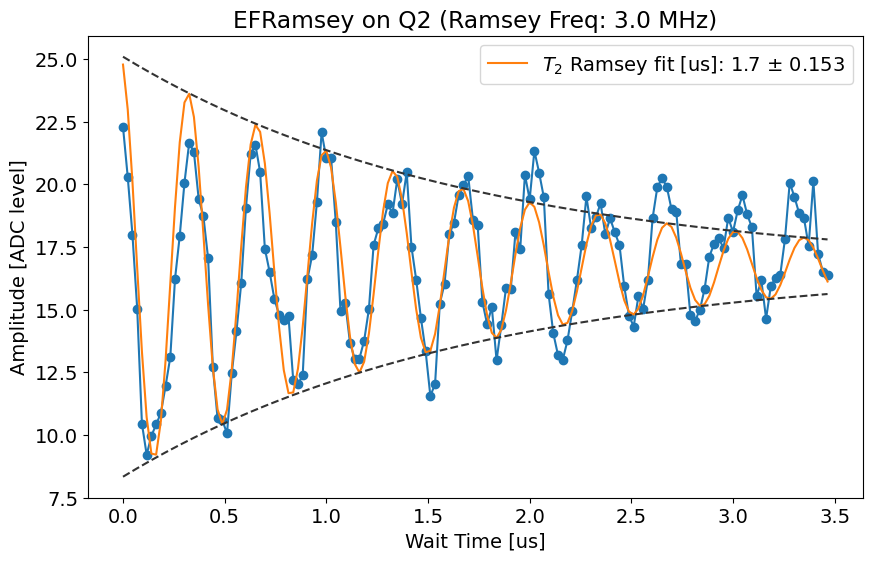

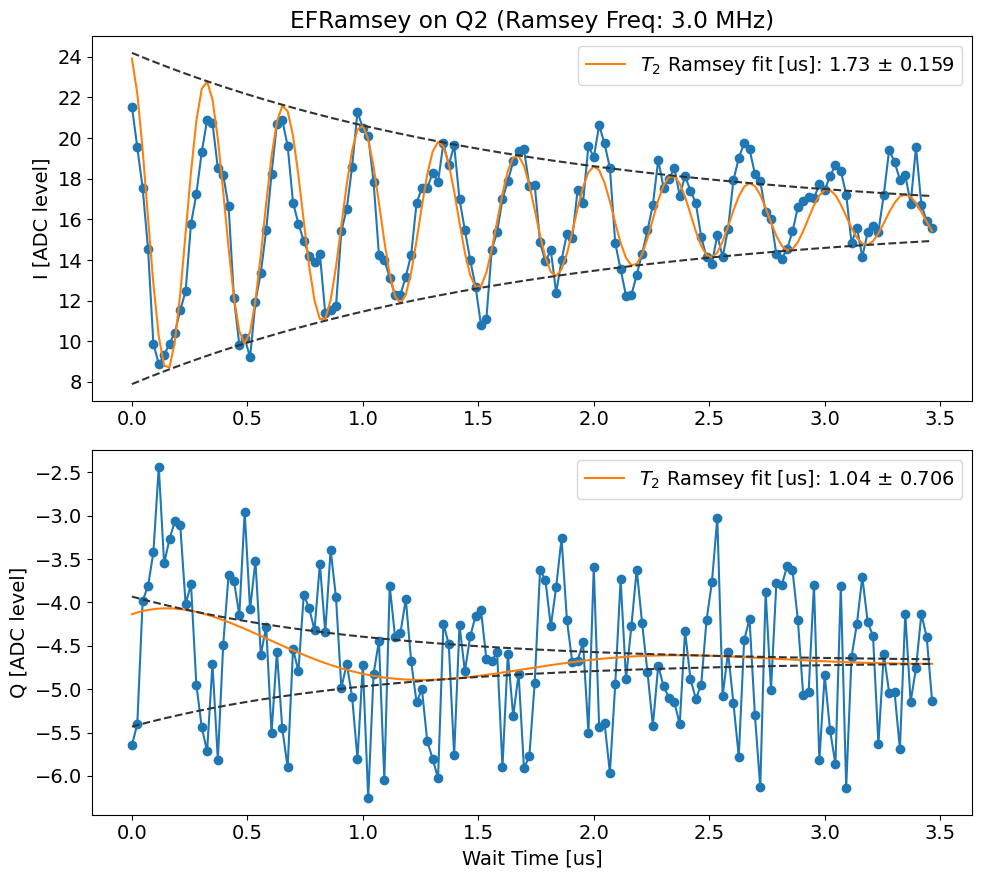

*Set qubit 2 EF freq to 4590.224612548705*
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453, 'T2R': 19.743050159012622, 'T2R err': 1.2349352829614832, 'Qubit freq': 3454.8307022222293}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1647, 'Qubit temp [mK]': 75.0116542249641, 'T2R': 10.571051685196025, 'T2R err': 0.7394386604494612, 'Qubit freq': 4779.441570799224, 'Pi pulse len': 0.015, 'Pi pulse gain': 2335, 't2EFR': 6.236049107142858, 't2EFR err': 1.1356721533115515, 'Qubit EF freq': 4590.224612548705}, {}]


In [83]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [ ]:
if save_data: saved_files.append(t2EFr.save_data())

## EF Ramsey Fringe Round 2


In [84]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramseyEF_qubit{qubit_i}",
    config_file=config_path,
)
t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(10) if t2EFr_fit[3] < 3 else soc.cycles2us(60), # [us]
    step=soc.cycles2us(40), # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=True,
    qubits=[qubit_i],
)
t2EFr_2.go(analyze=False, display=False, progress=True, save=False)

KeyboardInterrupt: 

Attempted to init fitparam 1 to 1.3858133333333336, which is out of bounds 0.004810738255033557 to 0.7216107382550335. Instead init to 0.3632107382550335
Current pi pulse frequency: 4590.174763658187
Fit frequency from amps [MHz]: 0.24415123428996674 +/- 0.004908614190944371
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4590.230612423897
 	4589.630612423897
T2 Ramsey from fit amps [us]: 6.236049107142858
Current pi pulse frequency: 4590.174763658187
Fit frequency from I [MHz]: 0.277828535110381 +/- 0.0045389903443165324
Suggested new pi pulse frequency from fit I [MHz]:
 	4590.196935123076
 	4589.596935123076
T2 Ramsey from fit I [us]: 6.236049107142858
Fit frequency from Q [MHz]: 0.2879329505355954 +/- 0.005217640060221429
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4590.186830707651
 	4589.586830707651
T2 Ramsey from fit Q [us]: 6.236049107142858


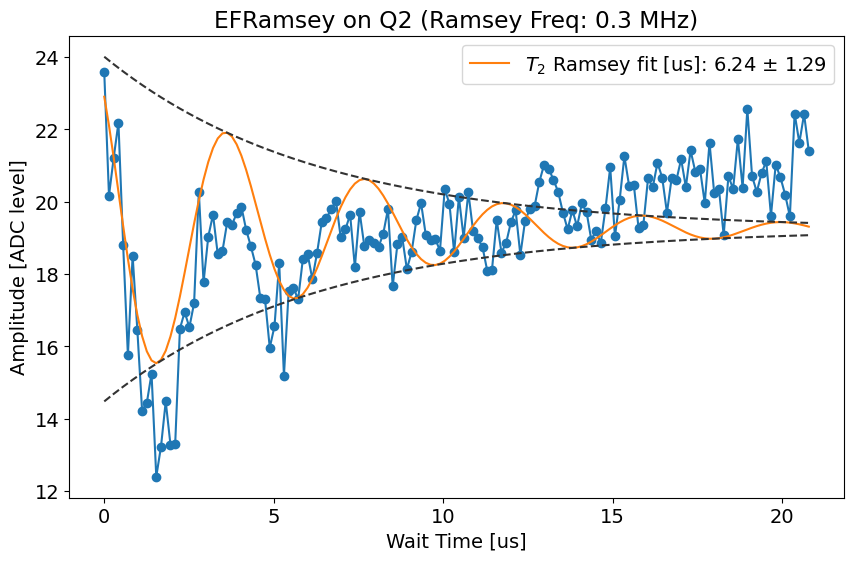

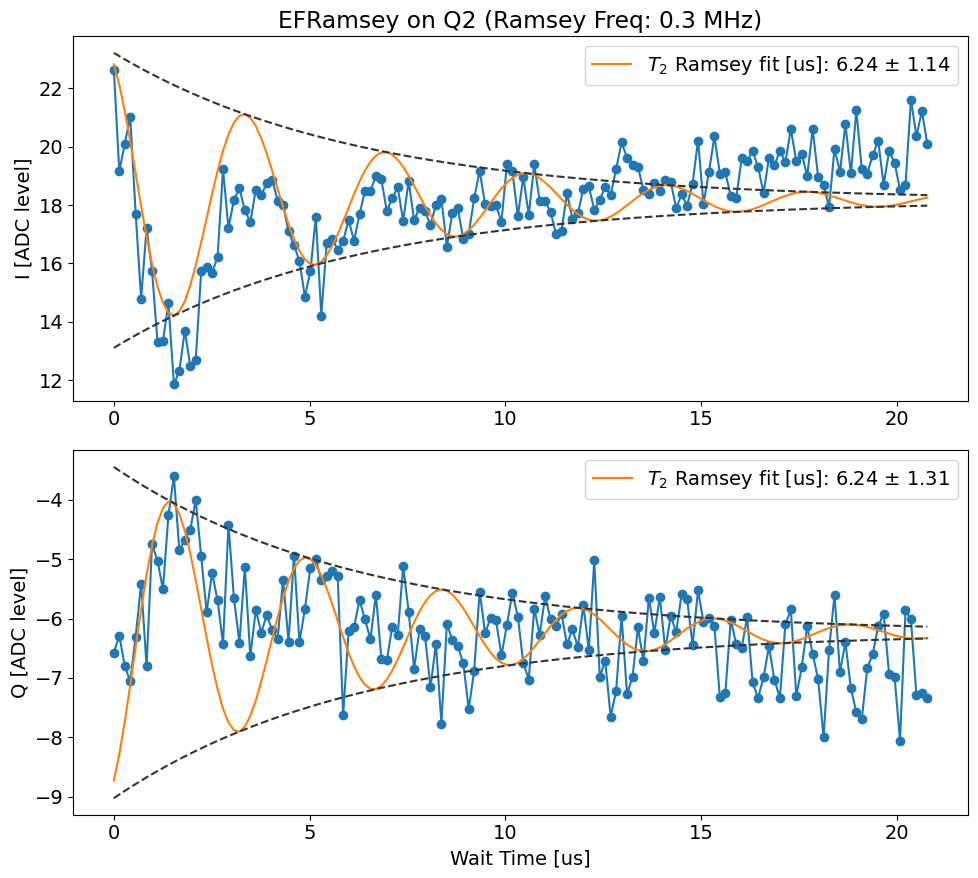

*Set qubit 2 EF freq to 4590.196935123076*
[{}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 498, 'Qubit temp [mK]': 86.88621011141453, 'T2R': 19.743050159012622, 'T2R err': 1.2349352829614832, 'Qubit freq': 3454.8307022222293}, {'EF pi pulse len': 0.015, 'EF pi pulse gain': 1647, 'Qubit temp [mK]': 75.0116542249641, 'T2R': 10.571051685196025, 'T2R err': 0.7394386604494612, 'Qubit freq': 4779.441570799224, 'Pi pulse len': 0.015, 'Pi pulse gain': 2335, 't2EFR': 6.236049107142858, 't2EFR err': 1.1356721533115515, 'Qubit EF freq': 4590.196935123076}, {}]


In [ ]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2EF.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)

t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])

t2EFr_2.display(fit=True)
final_qubit_freq = t2EFr_2.cfg.device.qubit.f_ef[qubit_i] + t2EFr_2_adjust[0]

yaml_cfg.device.qubit.f_ef[qubit_i] = final_qubit_freq
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'t2EFR':t2EFr_2_fit[3], 't2EFR err':np.sqrt(t2EFr_2_fit_err[3][3])})
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [ ]:
if save_data: saved_files.append(t2r_2.save_data())

# Resonator chi shift (e/f)

In [116]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-811.3625297153883, 5000, 1000, 0, 17.03715941066355, 326.477619610652]
[-8.03285761e+02 -3.03561876e+05 -1.27177254e+01  5.91794716e+00
 -1.27356982e+02  3.11150862e+02]

Freq with minimum transmission: -813.4817350134015
Freq with maximum transmission: -808.9453111723419
From fit:
	f0: -803.2857613940467
	Qi: -303561.8763070908
	Qe: -12.71772541526503
	Q0: -12.717192628454415
	kappa [MHz]: 63.165337261363334
	phi [radians]: 5.917947164978501


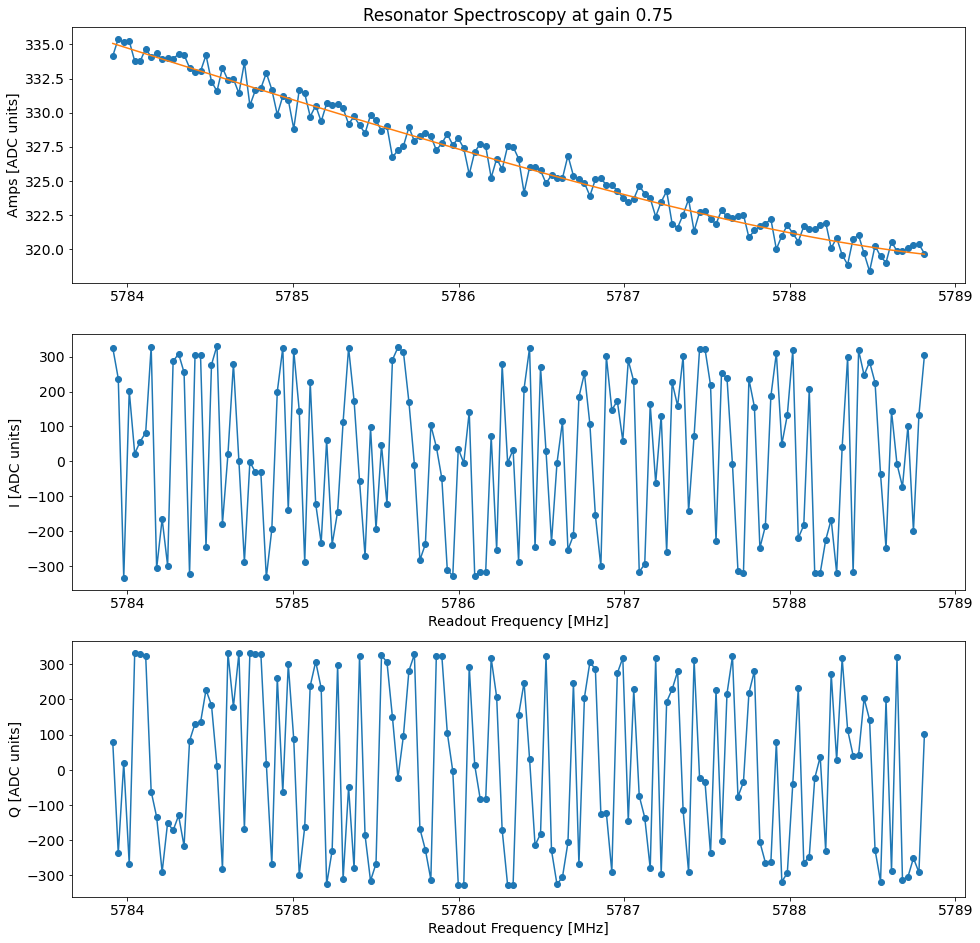

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [117]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [118]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_resonator_spectroscopy_chi_qubit1.h5


# Single Shot

## Single shot optimization

In [13]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [23]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.8
# npts_gain = 4
span_gain = 0.0
# npts_gain = 0

# span_len = 8 # us
# npts_len = 2
span_len = 5 # us
npts_len = 5

shotopt.cfg.expt = dict(
    reps=10000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    start_gain=0.95,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.25,
    # step_gain=0,
    # expts_gain=1,

    start_len=5,
    step_len=0,
    expts_len=1,
    # start_len=2,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.994651953712, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4588.124531178372, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.2, 5168.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1628, 1770], 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -815.502041072, gain: 0.1, len: 8
	fid ge [%]: 5.9705970597059705
freq: -815.502041072, gain: 0.30000000000000004, len: 8
	fid ge [%]: 13.490674533726688
freq: -815.502041072, gain: 0.5, len: 8
	fid ge [%]: 21.301065053252664
freq: -815.502041072, gain: 0.7000000000000001, len: 8
	fid ge [%]: 21.451072553627682
freq: -815.502041072, gain: 0.9, len: 8
	fid ge [%]: 24.431221561078054
freq: -815.472041072, gain: 0.1, len: 8
	fid ge [%]: 8.550427521376069
freq: -815.472041072, gain: 0.30000000000000004, len: 8
	fid ge [%]: 15.420771038551928
freq: -815.472041072, gain: 0.5, len: 8
	fid ge [%]: 22.23111155557778
freq: -815.472041072, gain: 0.7000000000000001, len: 8
	fid ge [%]: 22.501125056252814
freq: -815.472041072, gain: 0.9, len: 8
	fid ge [%]: 24.422442244224424
freq: -815.442041072, gain: 0.1, len: 8
	fid ge [%]: 8.790439521976099
freq: -815.442041072, gain: 0.30000000000000004, len: 8
	fid ge [%]: 17.300865043252163
freq: -815.442041072, gain: 0.5, len: 8
	fid ge [%]: 22.44112

(19, 4, 0)
[-815.50204107 -815.47204107 -815.44204107 -815.41204107 -815.38204107
 -815.35204107 -815.32204107 -815.29204107 -815.26204107 -815.23204107
 -815.20204107 -815.17204107 -815.14204107 -815.11204107 -815.08204107
 -815.05204107 -815.02204107 -814.99204107 -814.96204107 -814.93204107]
[0.1 0.3 0.5 0.7 0.9]
[8]
Max fidelity 38.10143042912874 %
Set params: 
 angle (deg) 147.55978416067143 
 threshold -933.6384789771145 
 freq [Mhz] -814.932041072 
 gain [dac units] 0.9 
 readout length [us] 8


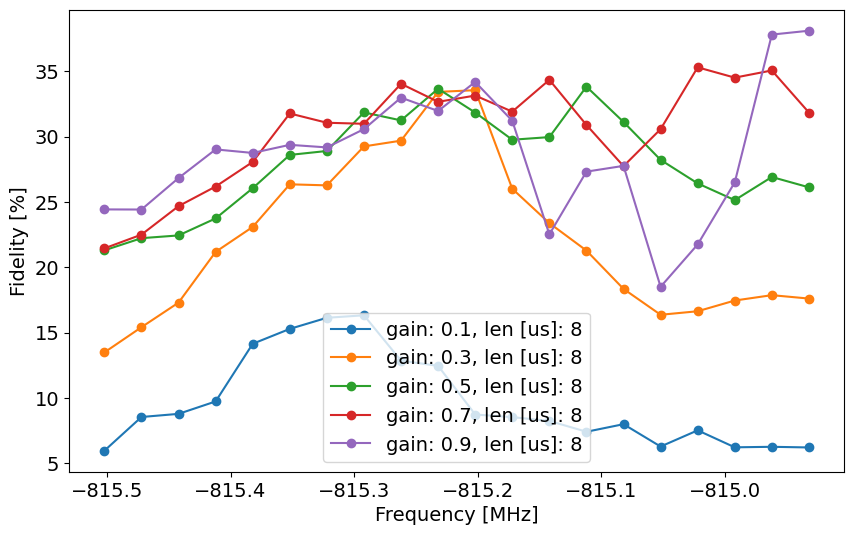

[[[0.05970597]
  [0.13490675]
  [0.21301065]
  [0.21451073]
  [0.24431222]]

 [[0.08550428]
  [0.15420771]
  [0.22231112]
  [0.22501125]
  [0.24422442]]

 [[0.0879044 ]
  [0.17300865]
  [0.22441122]
  [0.24681234]
  [0.26831342]]

 [[0.09740487]
  [0.21181059]
  [0.23741187]
  [0.26181309]
  [0.29021451]]

 [[0.14150708]
  [0.23091155]
  [0.26053908]
  [0.28062806]
  [0.28751438]]

 [[0.15290765]
  [0.26351318]
  [0.2860143 ]
  [0.31771589]
  [0.29371469]]

 [[0.16140807]
  [0.26271314]
  [0.28901445]
  [0.31061553]
  [0.29174376]]

 [[0.16330817]
  [0.29251463]
  [0.31851593]
  [0.30981549]
  [0.30573057]]

 [[0.12860643]
  [0.29691485]
  [0.31241562]
  [0.34041702]
  [0.32981649]]

 [[0.12461246]
  [0.33421671]
  [0.33661683]
  [0.32661633]
  [0.31961598]]

 [[0.08740874]
  [0.33551678]
  [0.31841592]
  [0.33141657]
  [0.34181709]]

 [[0.08540427]
  [0.26011301]
  [0.29761488]
  [0.31911596]
  [0.31211561]]

 [[0.08250413]
  [0.23382338]
  [0.29962996]
  [0.34343434]
  [0.22521126]]


In [24]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [89]:
qubit_i = 0
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [308]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: 88.10600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.56028900722518
freq: 88.10600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 16.100402510062754
freq: 88.10600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 18.745468636715916
freq: 88.10600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 13.435335883397084
freq: 88.10600000000001, gain: 0.8, len: 6.0
	fid ge [%]: 16.66041651041276
freq: 88.10600000000001, gain: 0.8, len: 10.0
	fid ge [%]: 21.835545888647214
freq: 88.10600000000001, gain: 0.95, len: 2.0
	fid ge [%]: 15.730393259831496
freq: 88.10600000000001, gain: 0.95, len: 6.0
	fid ge [%]: 20.906567992599445
freq: 88.10600000000001, gain: 0.95, len: 10.0
	fid ge [%]: 25.175629390734766
freq: 88.13600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.135556777838893
freq: 88.13600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 13.560678033901697
freq: 88.13600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 17.20043001075027
freq: 88.13600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 12.66031

(5, 2, 2)
[88.106 88.136 88.166 88.196 88.226 88.256 88.286 88.316 88.346 88.376
 88.406 88.436 88.466 88.496 88.526 88.556 88.586 88.616 88.646 88.676]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 39.22098052451311 %
Set params: 
 angle (deg) 63.21344812253799 
 threshold 1684.1831138018324 
 freq [Mhz] 88.25600000000001 
 gain [dac units] 0.95 
 readout length [us] 10.0


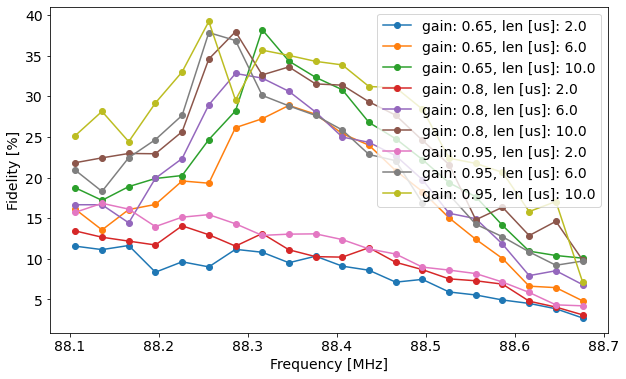

[[[0.11560289 0.16100403 0.18745469]
  [0.13435336 0.16660417 0.21835546]
  [0.15730393 0.20906568 0.25175629]]

 [[0.11135557 0.13560678 0.1720043 ]
  [0.12660317 0.16655416 0.22430561]
  [0.16835421 0.18300915 0.28151408]]

 [[0.11641164 0.16065402 0.18890472]
  [0.12180305 0.14435361 0.22970574]
  [0.16120403 0.22450561 0.24425611]]

 [[0.08355209 0.16695417 0.19890497]
  [0.11705585 0.19915498 0.22935573]
  [0.13970699 0.24675617 0.2918573 ]]

 [[0.09635241 0.19585979 0.20255506]
  [0.14065703 0.22345559 0.25651924]
  [0.15130378 0.27660692 0.33011651]]

 [[0.09010225 0.19310483 0.24675617]
  [0.12965648 0.28956448 0.34595865]
  [0.15440386 0.37850946 0.39220981]]

 [[0.11170279 0.26150654 0.28215705]
  [0.11565289 0.32816641 0.37963796]
  [0.14315358 0.36875922 0.29545739]]

 [[0.10810541 0.27245681 0.38205955]
  [0.13115328 0.32250806 0.32640816]
  [0.12885322 0.30120753 0.35690892]]

 [[0.09520238 0.28886444 0.34342576]
  [0.11115278 0.30620766 0.33625841]
  [0.13040326 0.288257

In [309]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [311]:
qubit_i = 1
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 2

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=2,
    step_len=span_len/npts_len,
    expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -813.75, gain: 0.65, len: 2.0
	fid ge [%]: 14.340358508962725
freq: -813.75, gain: 0.65, len: 6.0
	fid ge [%]: 23.005575139378482
freq: -813.75, gain: 0.65, len: 10.0
	fid ge [%]: 28.890722268056702
freq: -813.75, gain: 0.8, len: 2.0
	fid ge [%]: 16.430410760269005
freq: -813.75, gain: 0.8, len: 6.0
	fid ge [%]: 26.580664516612917
freq: -813.75, gain: 0.8, len: 10.0
	fid ge [%]: 33.311665583279165
freq: -813.75, gain: 0.95, len: 2.0
	fid ge [%]: 17.975449386234658
freq: -813.75, gain: 0.95, len: 6.0
	fid ge [%]: 29.321466073303665
freq: -813.75, gain: 0.95, len: 10.0
	fid ge [%]: 37.68188409420471
freq: -813.72, gain: 0.65, len: 2.0
	fid ge [%]: 15.325383134578363
freq: -813.72, gain: 0.65, len: 6.0
	fid ge [%]: 25.906295314765735
freq: -813.72, gain: 0.65, len: 10.0
	fid ge [%]: 33.45083627090678
freq: -813.72, gain: 0.8, len: 2.0
	fid ge [%]: 15.955398884972125
freq: -813.72, gain: 0.8, len: 6.0
	fid ge [%]: 30.445761144028598
freq: -813.72, gain: 0.8, len: 10.0
	fid ge [%]: 37

(12, 2, 2)
[-813.75 -813.72 -813.69 -813.66 -813.63 -813.6  -813.57 -813.54 -813.51
 -813.48 -813.45 -813.42 -813.39 -813.36 -813.33 -813.3  -813.27 -813.24
 -813.21 -813.18]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 72.19860993049653 %
Set params: 
 angle (deg) 59.10145895511285 
 threshold 144.57556226355138 
 freq [Mhz] -813.39 
 gain [dac units] 0.95 
 readout length [us] 10.0


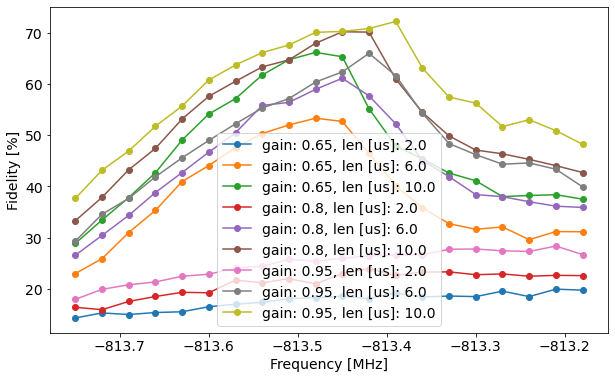

[[[0.14340359 0.23005575 0.28890722]
  [0.16430411 0.26580665 0.33311666]
  [0.17975449 0.29321466 0.37681884]]

 [[0.15325383 0.25906295 0.33450836]
  [0.15955399 0.30445761 0.37875947]
  [0.19925498 0.34580865 0.43176079]]

 [[0.15011126 0.31010775 0.37835946]
  [0.17565439 0.34355859 0.43256081]
  [0.20820521 0.37675942 0.46921173]]

 [[0.15405385 0.35330883 0.42676067]
  [0.18530927 0.38821941 0.47428557]
  [0.21370534 0.41877094 0.51746294]]

 [[0.15550778 0.40966024 0.49059906]
  [0.19345484 0.42721068 0.53166329]
  [0.22480562 0.4559842  0.55696392]]

 [[0.16535413 0.44081102 0.54137707]
  [0.19255481 0.46696167 0.5759144 ]
  [0.22880572 0.48976224 0.60766519]]

 [[0.17036278 0.4759119  0.57137857]
  [0.21730543 0.50476262 0.60521513]
  [0.24071204 0.52222611 0.63713186]]

 [[0.17385435 0.50336258 0.61744631]
  [0.2119053  0.55817791 0.63331583]
  [0.24430611 0.55311383 0.66111653]]

 [[0.18120453 0.520013   0.64733237]
  [0.2201055  0.5640282  0.64696617]
  [0.25770644 0.571414

In [313]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [172]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=30000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain=gain_opt
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency = 819.538
# shot.cfg.device.readout.gain = 0.65
# shot.cfg.device.readout.readout_length = 2

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain=0.95
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.0, 58.0, 46.0, 43.0], 'f_ge': [4129.446891895333, 3454.9960740021306, 4779.596097510133, 4394.480407282836], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3903.416022184577, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_EgGf': [2681.44696031, -1, 2028.5, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.5, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [27232, 947, 2325, 2511], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [27083, 499, 1633, 1

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Unrotated:
Ig 39.004270028466856 +/- 23.01419279332558 	 Qg -96.80601870679138 +/- 23.585152565728162 	 Amp g 104.3682822428021
Ie 22.706994713298087 +/- 23.773533034550017 	 Qe -64.96502643350955 +/- 26.76652136480589 	 Amp e 68.81905454462697
Rotated:
Ig -104.1458285688447 +/- 23.01419279332558 	 Qg 9.209982826600253 +/- 23.585152565728162 	 Amp g 104.55227109899366
Ie -67.6783074890875 +/- 23.773533034550017 	 Qe 9.728610360081245 +/- 26.76652136480589 	 Amp e 68.37396554336861


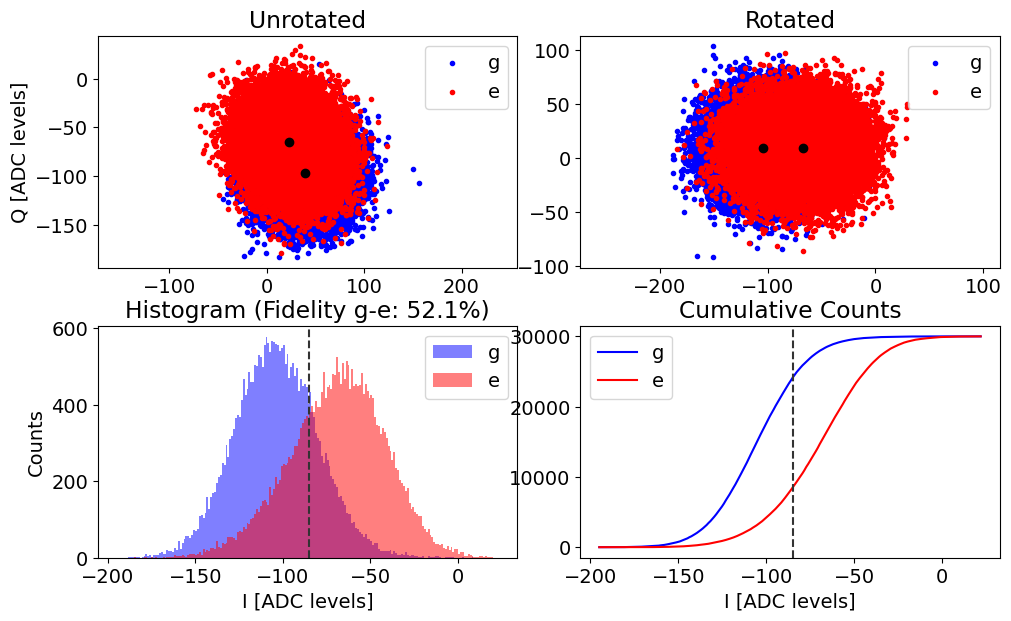

ge fidelity (%): 52.143476231748785
rotation angle (deg): -117.10487157566352
threshold ge: -84.82206685524133


In [173]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [174]:
if save_data: saved_files.append(shot.save_data())

# Results

In [175]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'qubit': {'T1': [45.0, 58.0, 46.0, 43.0], 'f_ge': [4129.446891895333, 3454.9960740021306, 4779.596097510133, 4394.480407282836], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3903.416022184577, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_EgGf': [2681.44696031, -1, 2028.5, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.5, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [27232, 947, 2325, 2511], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [27083, 499, 1633, 1